In [3]:
import os
import pickle
import pandas as pd
import numpy as np
from scipy.stats import kurtosis, skew
from scipy.fftpack import fft
from scipy.signal import hilbert
import pywt
from tqdm import tqdm
from pyts.decomposition import SingularSpectrumAnalysis  # Importar SSA

def extract_features(signal, prefix, sampling_rate=6400):
    # Asegurarse de que la señal es numérica
    signal = pd.to_numeric(signal, errors='coerce')
    # Eliminar valores NaN
    signal = signal.dropna()
    if len(signal) == 0:
        return {}  # Retornar un diccionario vacío si la señal está vacía después de eliminar NaNs
    # Convertir a array de numpy
    signal = signal.to_numpy()
    
    features = {}
    
    try:
        # Características del dominio del tiempo
        features[f'{prefix}_mean'] = np.mean(signal)
        features[f'{prefix}_std'] = np.std(signal)
        features[f'{prefix}_max'] = np.max(signal)
        features[f'{prefix}_min'] = np.min(signal)
        features[f'{prefix}_ptp'] = np.ptp(signal)
        features[f'{prefix}_kurtosis'] = kurtosis(signal)
        features[f'{prefix}_skewness'] = skew(signal)
        features[f'{prefix}_rms'] = np.sqrt(np.mean(signal**2))
        features[f'{prefix}_crest_factor'] = np.max(np.abs(signal)) / features[f'{prefix}_rms']

        # Transformada de Fourier
        freqs = fft(signal)
        freqs_abs = np.abs(freqs)
        freqs_norm = freqs_abs / len(signal)  # Normalizar la magnitud de la FFT
        freqs_indices = np.fft.fftfreq(len(signal), 1/sampling_rate)
        
        # Solo extraer los primeros 5 armónicos
        num_harmonics = 5
        for i in range(1, num_harmonics + 1):
            harmonic_index = i
            if harmonic_index < len(freqs_norm):
                features[f'{prefix}_harmonic_{i}_amplitude'] = freqs_norm[harmonic_index]
            else:
                features[f'{prefix}_harmonic_{i}_amplitude'] = 0  # Si el armónico está fuera del rango de la FFT

        # Envelope analysis
        analytic_signal = hilbert(signal)
        amplitude_envelope = np.abs(analytic_signal)
        features[f'{prefix}_envelope_mean'] = np.mean(amplitude_envelope)
        features[f'{prefix}_envelope_std'] = np.std(amplitude_envelope)

        # Transformada Wavelet
        coeffs = pywt.wavedec(signal, 'db1', level=5)
        for i in range(1, num_harmonics + 1):
            if i < len(coeffs):
                features[f'{prefix}_wavelet_{i}_mean'] = np.mean(coeffs[i])
                features[f'{prefix}_wavelet_{i}_std'] = np.std(coeffs[i])
            else:
                features[f'{prefix}_wavelet_{i}_mean'] = 0
                features[f'{prefix}_wavelet_{i}_std'] = 0

        # Singular Spectrum Analysis (SSA)
        window_size = 50  # Tamaño de ventana ajustable
        groups = num_harmonics  # Solo los primeros 5 componentes
        ssa = SingularSpectrumAnalysis(window_size=window_size, groups=groups)
        components = ssa.fit_transform(signal.reshape(1, -1))
        for i in range(components.shape[0]):
            features[f'{prefix}_ssa_{i+1}_mean'] = np.mean(components[i])
            features[f'{prefix}_ssa_{i+1}_std'] = np.std(components[i])

    except Exception as e:
        print(f"Error al extraer características de {prefix}: {e}")
    
    return features

def get_label_from_filename(filename):
    if '(Fault) Bearing (1) Fault (combination) Trial' in filename:
        return 1  # Indicador de fallo
    elif '(NoFault)' in filename:
        return 0  # Indicador de no fallo
    else:
        return None  # Etiqueta desconocida

# Directorio donde se encuentran los archivos PLK
directory = 'C:/Users/orzus/OneDrive/Documentos/1C 2024/IA/TP/dataset_plk/split25_plk'
output_file = 'C:/Users/orzus/OneDrive/Documentos/1C 2024/IA/TP/features_dataset25mod.csv'

features_list = []

# Columnas de interés (vibración)
columns_of_interest = ['Tachometer', 'Motor', 'Bearing 1 Z', 'Bearing 1 Y', 'Bearing 1 X',
                      'Bearing 2 Z', 'Bearing 2 Y', 'Bearing 2 X', 'Gearbox']

# Recorrer todos los archivos en el directorio
for filename in tqdm(os.listdir(directory)):
    if filename.endswith(".plk"):
        file_path = os.path.join(directory, filename)
        try:
            with open(file_path, 'rb') as f:
                data = pickle.load(f)
        except Exception as e:
            print(f"Error al cargar {filename}: {e}")
            continue
        
        label = get_label_from_filename(filename)
        
        if label is not None:
            file_features = {'file': filename, 'label': label}
            for col in columns_of_interest:
                if col in data:
                    signal = data[col]
                    col_features = extract_features(signal, col)
                    file_features.update(col_features)
            features_list.append(file_features)

df_features = pd.DataFrame(features_list)
df_features.to_csv(output_file, index=False)
print(f'Características extraídas y guardadas en {output_file}')

100%|████████████████████████████████████████████████████████████████████████████████| 975/975 [14:46<00:00,  1.10it/s]

Características extraídas y guardadas en C:/Users/orzus/OneDrive/Documentos/1C 2024/IA/TP/features_dataset25mod.csv


In [5]:
df=pd.read_csv("C:/Users/orzus/OneDrive/Documentos/1C 2024/IA/TP/features_dataset25mod.csv")

In [15]:
df.shape

(50, 254)

In [11]:
df.head()

,file,label,Tachometer_mean,Tachometer_std,Tachometer_max,Tachometer_min,Tachometer_ptp,Tachometer_kurtosis,Tachometer_skewness,Tachometer_rms,...,Gearbox_wavelet_2_mean,Gearbox_wavelet_2_std,Gearbox_wavelet_3_mean,Gearbox_wavelet_3_std,Gearbox_wavelet_4_mean,Gearbox_wavelet_4_std,Gearbox_wavelet_5_mean,Gearbox_wavelet_5_std,Gearbox_ssa_1_mean,Gearbox_ssa_1_std
0,(Fault) Bearing (1) Fault (combination) Trial ...,1,0.001087,1.817144,4.362255,-1.269511,5.631766,0.885078,1.692574,1.817144,...,8.496700e-06,0.001258,-6.600283e-06,0.001190,0.000024,0.001136,-8.105669e-08,0.000947,0.001553,0.003139
1,(Fault) Bearing (1) Fault (combination) Trial ...,1,0.000719,1.855127,4.395543,-1.304413,5.699956,0.767611,1.657800,1.855127,...,-3.783981e-05,0.001334,1.156290e-06,0.001613,0.000040,0.001745,-2.894861e-08,0.001648,0.001702,0.003459
2,(Fault) Bearing (1) Fault (combination) Trial ...,1,0.000525,1.854836,4.396760,-1.303915,5.700675,0.770582,1.658567,1.854836,...,-9.989241e-07,0.001300,1.390029e-05,0.001558,-0.000004,0.001706,1.397804e-07,0.001615,0.001694,0.003443
3,(Fault) Bearing (1) Fault (combination) Trial ...,1,0.000168,1.854508,4.395790,-1.303743,5.699533,0.772295,1.659318,1.854508,...,-4.117345e-06,0.001334,6.219815e-07,0.001636,0.000006,0.001790,-2.150468e-08,0.001661,0.001656,0.003366
4,(Fault) Bearing (1) Fault (combination) Trial ...,1,-0.000182,1.854050,4.396962,-1.303833,5.700795,0.776238,1.660350,1.854050,...,2.021242e-06,0.001343,-6.941049e-06,0.001628,0.000011,0.001733,-1.538412e-07,0.001645,0.001671,0.003399


In [12]:
import os
import pickle
import pandas as pd
import numpy as np
from scipy.fftpack import fft
from tqdm import tqdm

def extract_harmonics(signal, prefix, sampling_rate=6400):
    signal = pd.to_numeric(signal, errors='coerce').dropna().to_numpy()
    if len(signal) == 0:
        return {}

    features = {}
    
    try:
        # Transformada de Fourier (FFT)
        freqs = fft(signal)
        freqs_abs = np.abs(freqs)
        freqs_norm = freqs_abs / len(signal)
        freqs_indices = np.fft.fftfreq(len(signal), 1/sampling_rate)
        
        # Solo extraer los primeros 10 armónicos
        num_harmonics = 10
        for i in range(1, num_harmonics + 1):
            harmonic_index = i
            if harmonic_index < len(freqs_norm):
                features[f'{prefix}_harmonic_{i}_amplitude'] = freqs_norm[harmonic_index]
            else:
                features[f'{prefix}_harmonic_{i}_amplitude'] = 0

    except Exception as e:
        print(f"Error al extraer armónicos de {prefix}: {e}")
    
    return features

def get_label_from_filename(filename):
    if '(Fault) Bearing (1) Ball & Bearing (2) Combination' in filename:
        return 1
    elif '(NoFault)' in filename:
        return 0
    else:
        return None

def process_file(file_path, filename, columns_of_interest):
    try:
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
    except Exception as e:
        print(f"Error al cargar {filename}: {e}")
        return None
    
    label = get_label_from_filename(filename)
    
    if label is not None:
        file_features = {'file': filename, 'label': label}
        for col in columns_of_interest:
            if col in data:
                signal = data[col]
                col_features = extract_harmonics(signal, col)
                file_features.update(col_features)
        return file_features
    return None

directory = 'C:/Users/orzus/OneDrive/Documentos/1C 2024/IA/TP/dataset_plk/split25_plk'
output_file = 'C:/Users/orzus/OneDrive/Documentos/1C 2024/IA/TP/features_harmonics_be1_babe2_comb.csv'

columns_of_interest = ['Tachometer', 'Motor', 'Bearing 1 Z', 'Bearing 1 Y', 'Bearing 1 X',
                      'Bearing 2 Z', 'Bearing 2 Y', 'Bearing 2 X', 'Gearbox']

features_list = []

# Enfoque secuencial para depuración
for filename in tqdm(os.listdir(directory)):
    if filename.endswith(".plk"):
        file_path = os.path.join(directory, filename)
        result = process_file(file_path, filename, columns_of_interest)
        if result is not None:
            features_list.append(result)

df_features = pd.DataFrame(features_list)
df_features.to_csv(output_file, index=False)
print(f'Características de armónicos extraídas y guardadas en {output_file}')

100%|████████████████████████████████████████████████████████████████████████████████| 975/975 [00:51<00:00, 19.06it/s]

Características de armónicos extraídas y guardadas en C:/Users/orzus/OneDrive/Documentos/1C 2024/IA/TP/features_harmonics_be1_babe2_comb.csv


In [26]:
df_harm=pd.read_csv("C:/Users/orzus/OneDrive/Documentos/1C 2024/IA/TP/features_harmonics_be1_babe2_comb.csv")

In [28]:
df_harm.shape

(50, 47)

In [29]:
df_harm.head()

,file,label,Tachometer_harmonic_1_amplitude,Tachometer_harmonic_2_amplitude,Tachometer_harmonic_3_amplitude,Tachometer_harmonic_4_amplitude,Tachometer_harmonic_5_amplitude,Motor_harmonic_1_amplitude,Motor_harmonic_2_amplitude,Motor_harmonic_3_amplitude,...,Bearing 2 X_harmonic_1_amplitude,Bearing 2 X_harmonic_2_amplitude,Bearing 2 X_harmonic_3_amplitude,Bearing 2 X_harmonic_4_amplitude,Bearing 2 X_harmonic_5_amplitude,Gearbox_harmonic_1_amplitude,Gearbox_harmonic_2_amplitude,Gearbox_harmonic_3_amplitude,Gearbox_harmonic_4_amplitude,Gearbox_harmonic_5_amplitude
0,(Fault) Bearing (1) Ball & Bearing (2) Combina...,1,0.000006,0.000005,0.000003,0.000001,0.000002,0.000029,0.000062,0.000006,...,0.000044,0.000107,0.000104,0.000099,0.000084,0.000046,0.000022,0.000014,0.000021,0.000006
1,(Fault) Bearing (1) Ball & Bearing (2) Combina...,1,0.000023,0.000015,0.000021,0.000007,0.000003,0.000017,0.000027,0.000020,...,0.000083,0.000057,0.000055,0.000073,0.000065,0.000046,0.000022,0.000015,0.000011,0.000011
2,(Fault) Bearing (1) Ball & Bearing (2) Combina...,1,0.000019,0.000008,0.000006,0.000011,0.000009,0.000041,0.000015,0.000023,...,0.000043,0.000017,0.000050,0.000032,0.000093,0.000051,0.000022,0.000010,0.000016,0.000003
3,(Fault) Bearing (1) Ball & Bearing (2) Combina...,1,0.000020,0.000009,0.000010,0.000002,0.000004,0.000028,0.000016,0.000028,...,0.000057,0.000028,0.000060,0.000099,0.000073,0.000017,0.000039,0.000018,0.000015,0.000012
4,(Fault) Bearing (1) Ball & Bearing (2) Combina...,1,0.000021,0.000010,0.000011,0.000005,0.000006,0.000044,0.000016,0.000013,...,0.000034,0.000026,0.000025,0.000074,0.000040,0.000017,0.000027,0.000013,0.000004,0.000009


In [31]:
import pandas as pd

# Cargar el archivo CSV de características
df_features = pd.read_csv('C:/Users/orzus/OneDrive/Documentos/1C 2024/IA/TP/features_harmonics_be1_babe2_comb.csv')

# Filtrar los datos por escenarios de falla y no falla
df_fault = df_features[df_features['label'] == 1]
df_no_fault = df_features[df_features['label'] == 0]


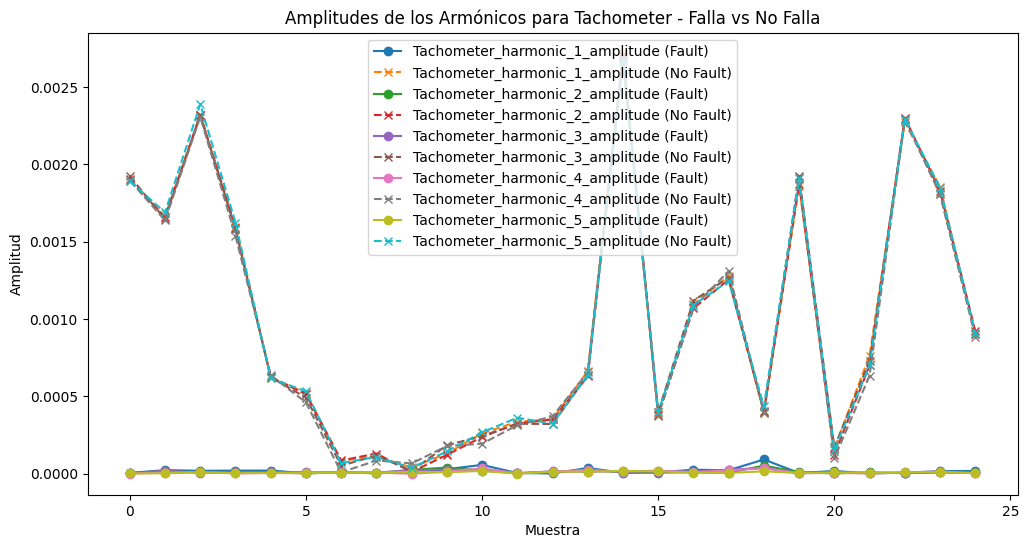

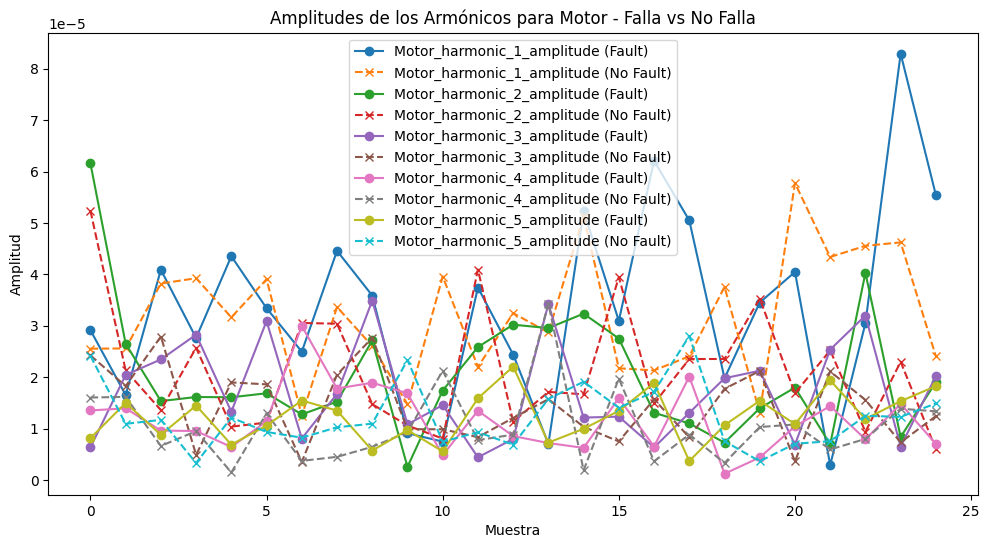

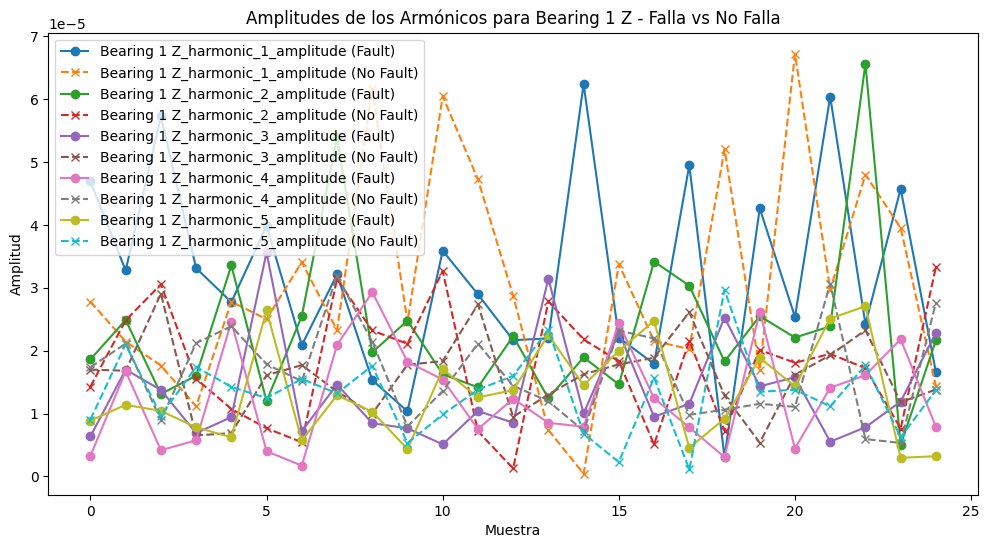

In [32]:
import matplotlib.pyplot as plt

# Función para plotear los armónicos de escenarios de falla y no falla superpuestos
def plot_harmonics_comparison(df_fault, df_no_fault, prefix):
    harmonics = [f'{prefix}_harmonic_{i}_amplitude' for i in range(1, 11)]
    
    plt.figure(figsize=(12, 6))
    
    for harmonic in harmonics:
        plt.plot(df_fault[harmonic].values, label=f'{harmonic} (Fault)', linestyle='-', marker='o')
        plt.plot(df_no_fault[harmonic].values, label=f'{harmonic} (No Fault)', linestyle='--', marker='x')
    
    plt.xlabel('Muestra')
    plt.ylabel('Amplitud')
    plt.title(f'Amplitudes de los Armónicos para {prefix} - Falla vs No Falla')
    plt.legend()
    plt.show()

# Plottear los armónicos superpuestos para 'Tachometer'
plot_harmonics_comparison(df_fault, df_no_fault, 'Tachometer')

# Plottear los armónicos superpuestos para 'Motor'
plot_harmonics_comparison(df_fault, df_no_fault, 'Motor')

# Plottear los armónicos superpuestos para 'Bearing 1 Z'
plot_harmonics_comparison(df_fault, df_no_fault, 'Bearing 1 Z')

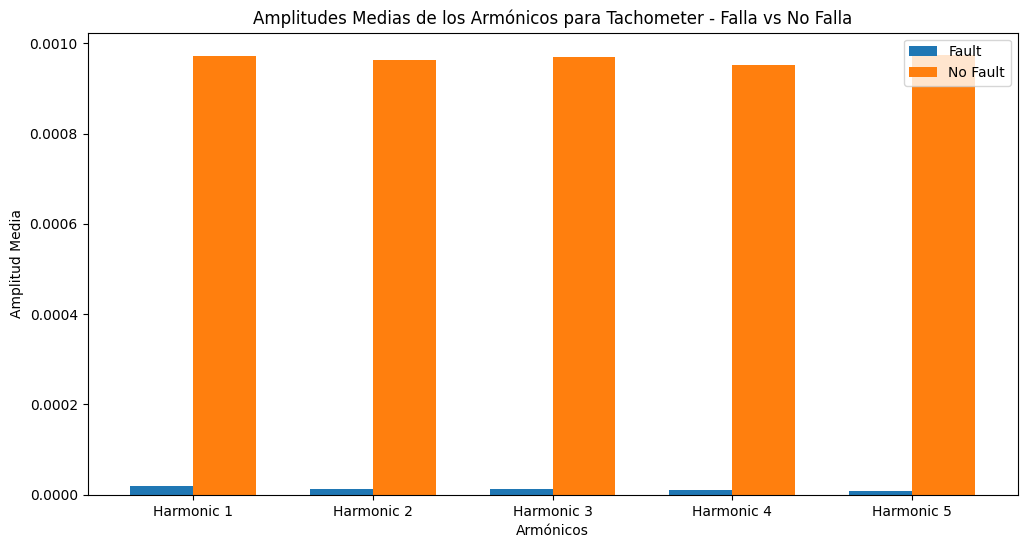

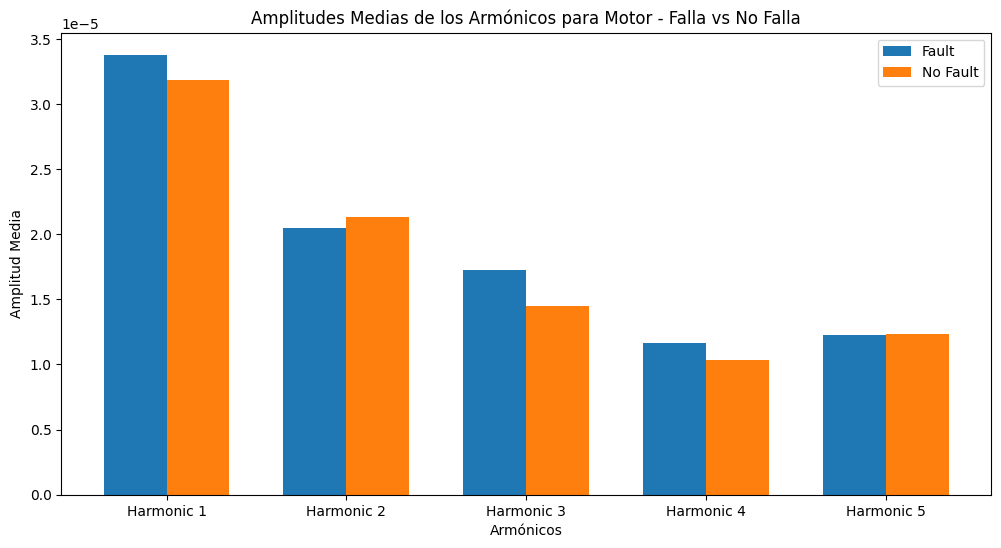

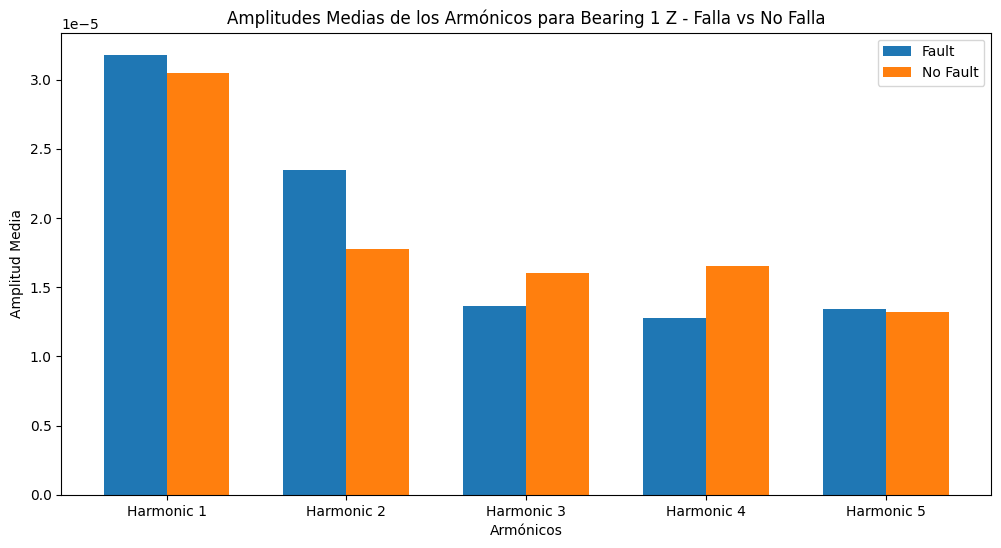

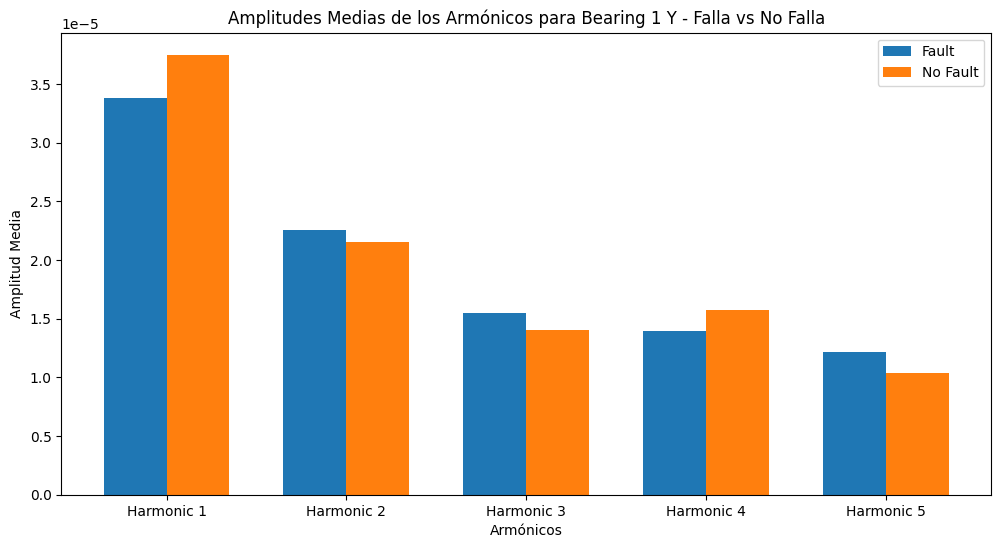

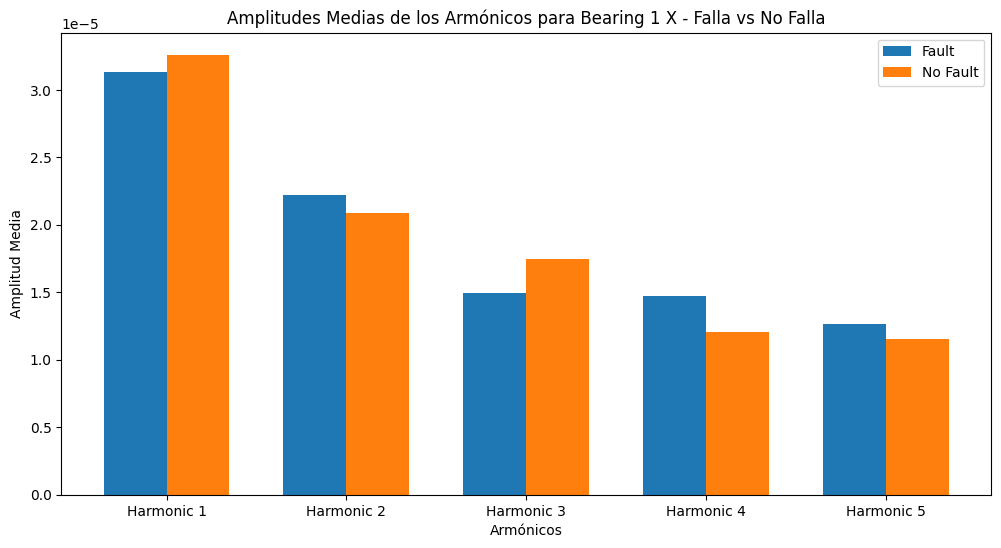

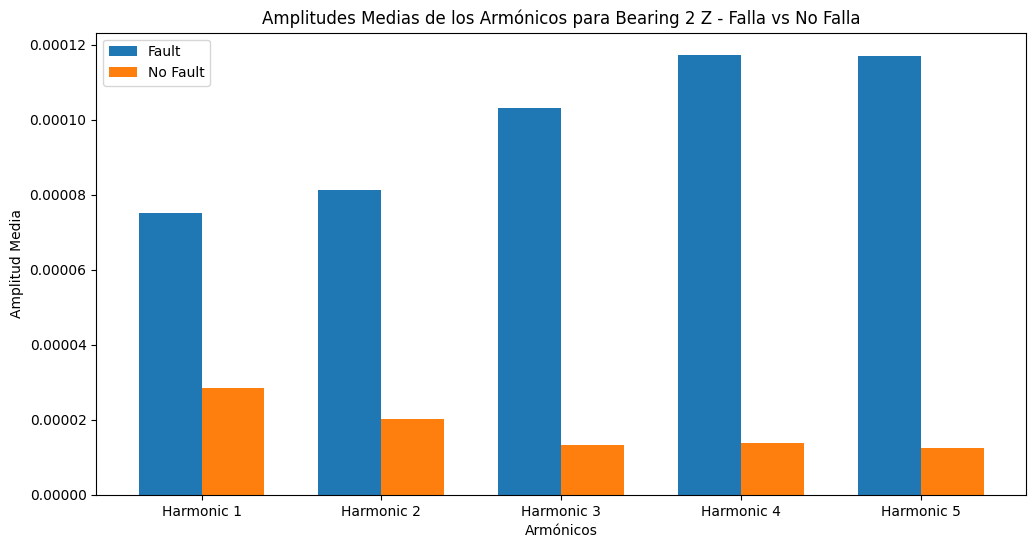

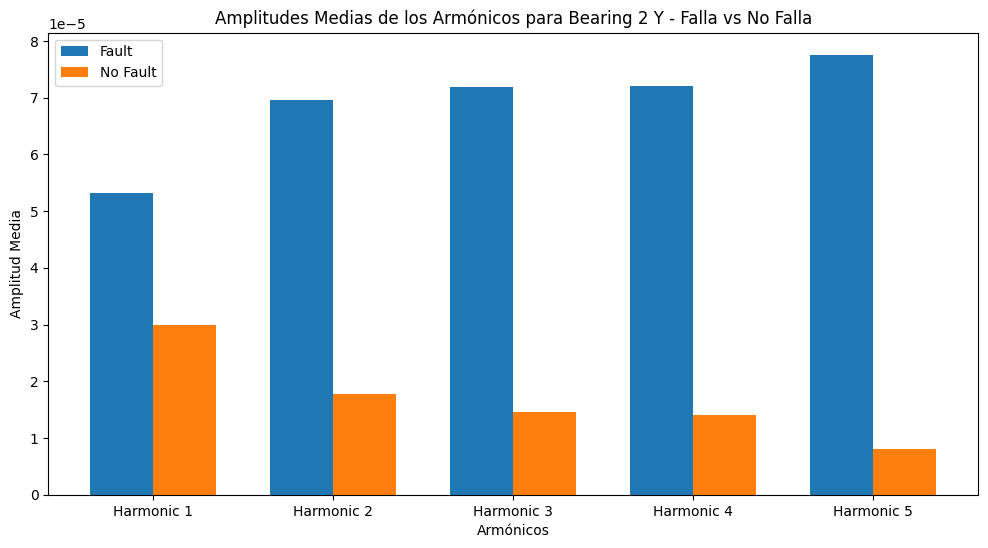

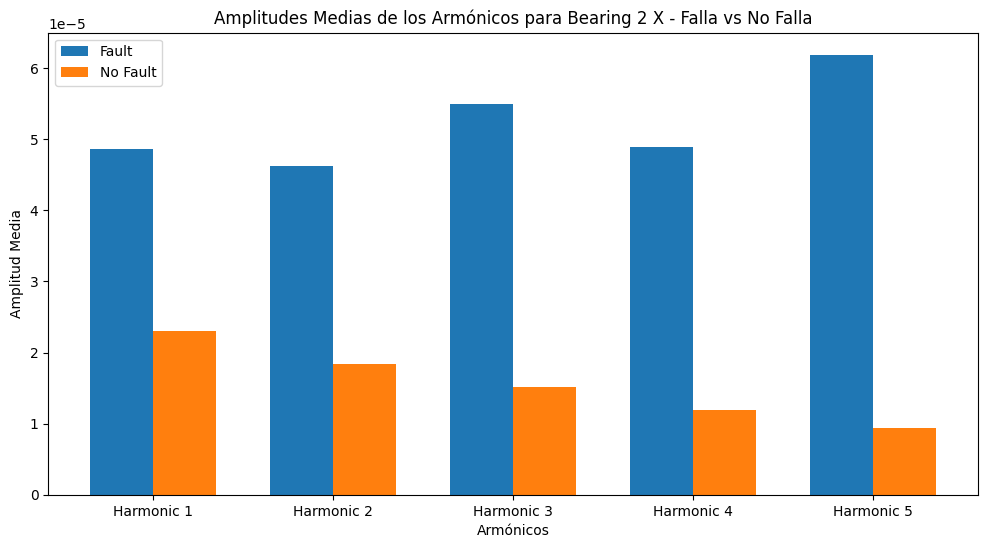

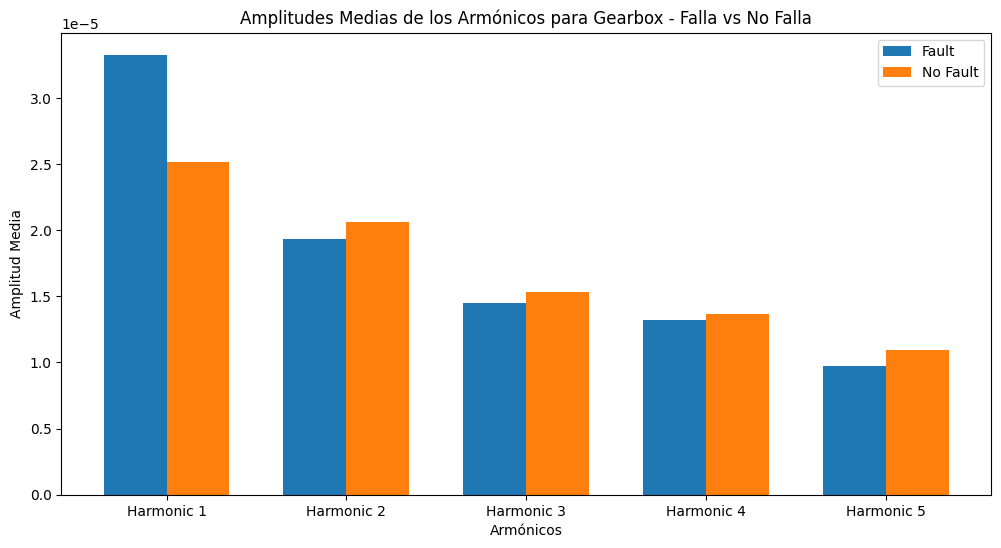

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Cargar el archivo CSV de características
df_features = pd.read_csv('C:/Users/orzus/OneDrive/Documentos/1C 2024/IA/TP/features_harmonics_be1_babe2_comb.csv')

# Filtrar los datos por escenarios de falla y no falla
df_fault = df_features[df_features['label'] == 1]
df_no_fault = df_features[df_features['label'] == 0]

# Función para plotear los armónicos de escenarios de falla y no falla superpuestos en gráficos de barras
def plot_harmonics_comparison_bar(df_fault, df_no_fault, prefix):
    harmonics = [f'{prefix}_harmonic_{i}_amplitude' for i in range(1, 11)]
    
    num_bars = len(harmonics)
    bar_width = 0.35
    index = np.arange(num_bars)
    
    fault_means = [df_fault[harmonic].mean() for harmonic in harmonics]
    no_fault_means = [df_no_fault[harmonic].mean() for harmonic in harmonics]
    
    plt.figure(figsize=(12, 6))
    
    bar1 = plt.bar(index, fault_means, bar_width, label='Fault')
    bar2 = plt.bar(index + bar_width, no_fault_means, bar_width, label='No Fault')
    
    plt.xlabel('Armónicos')
    plt.ylabel('Amplitud Media')
    plt.title(f'Amplitudes Medias de los Armónicos para {prefix} - Falla vs No Falla')
    plt.xticks(index + bar_width / 2, [f'H {i}' for i in range(1, 11)])
    plt.legend()
    
    plt.show()

# Lista de columnas de interés
columns_of_interest = ['Tachometer', 'Motor', 'Bearing 1 Z', 'Bearing 1 Y', 'Bearing 1 X',
                      'Bearing 2 Z', 'Bearing 2 Y', 'Bearing 2 X', 'Gearbox']

# Crear gráficos de barras para cada columna de interés
for col in columns_of_interest:
    plot_harmonics_comparison_bar(df_fault, df_no_fault, col)

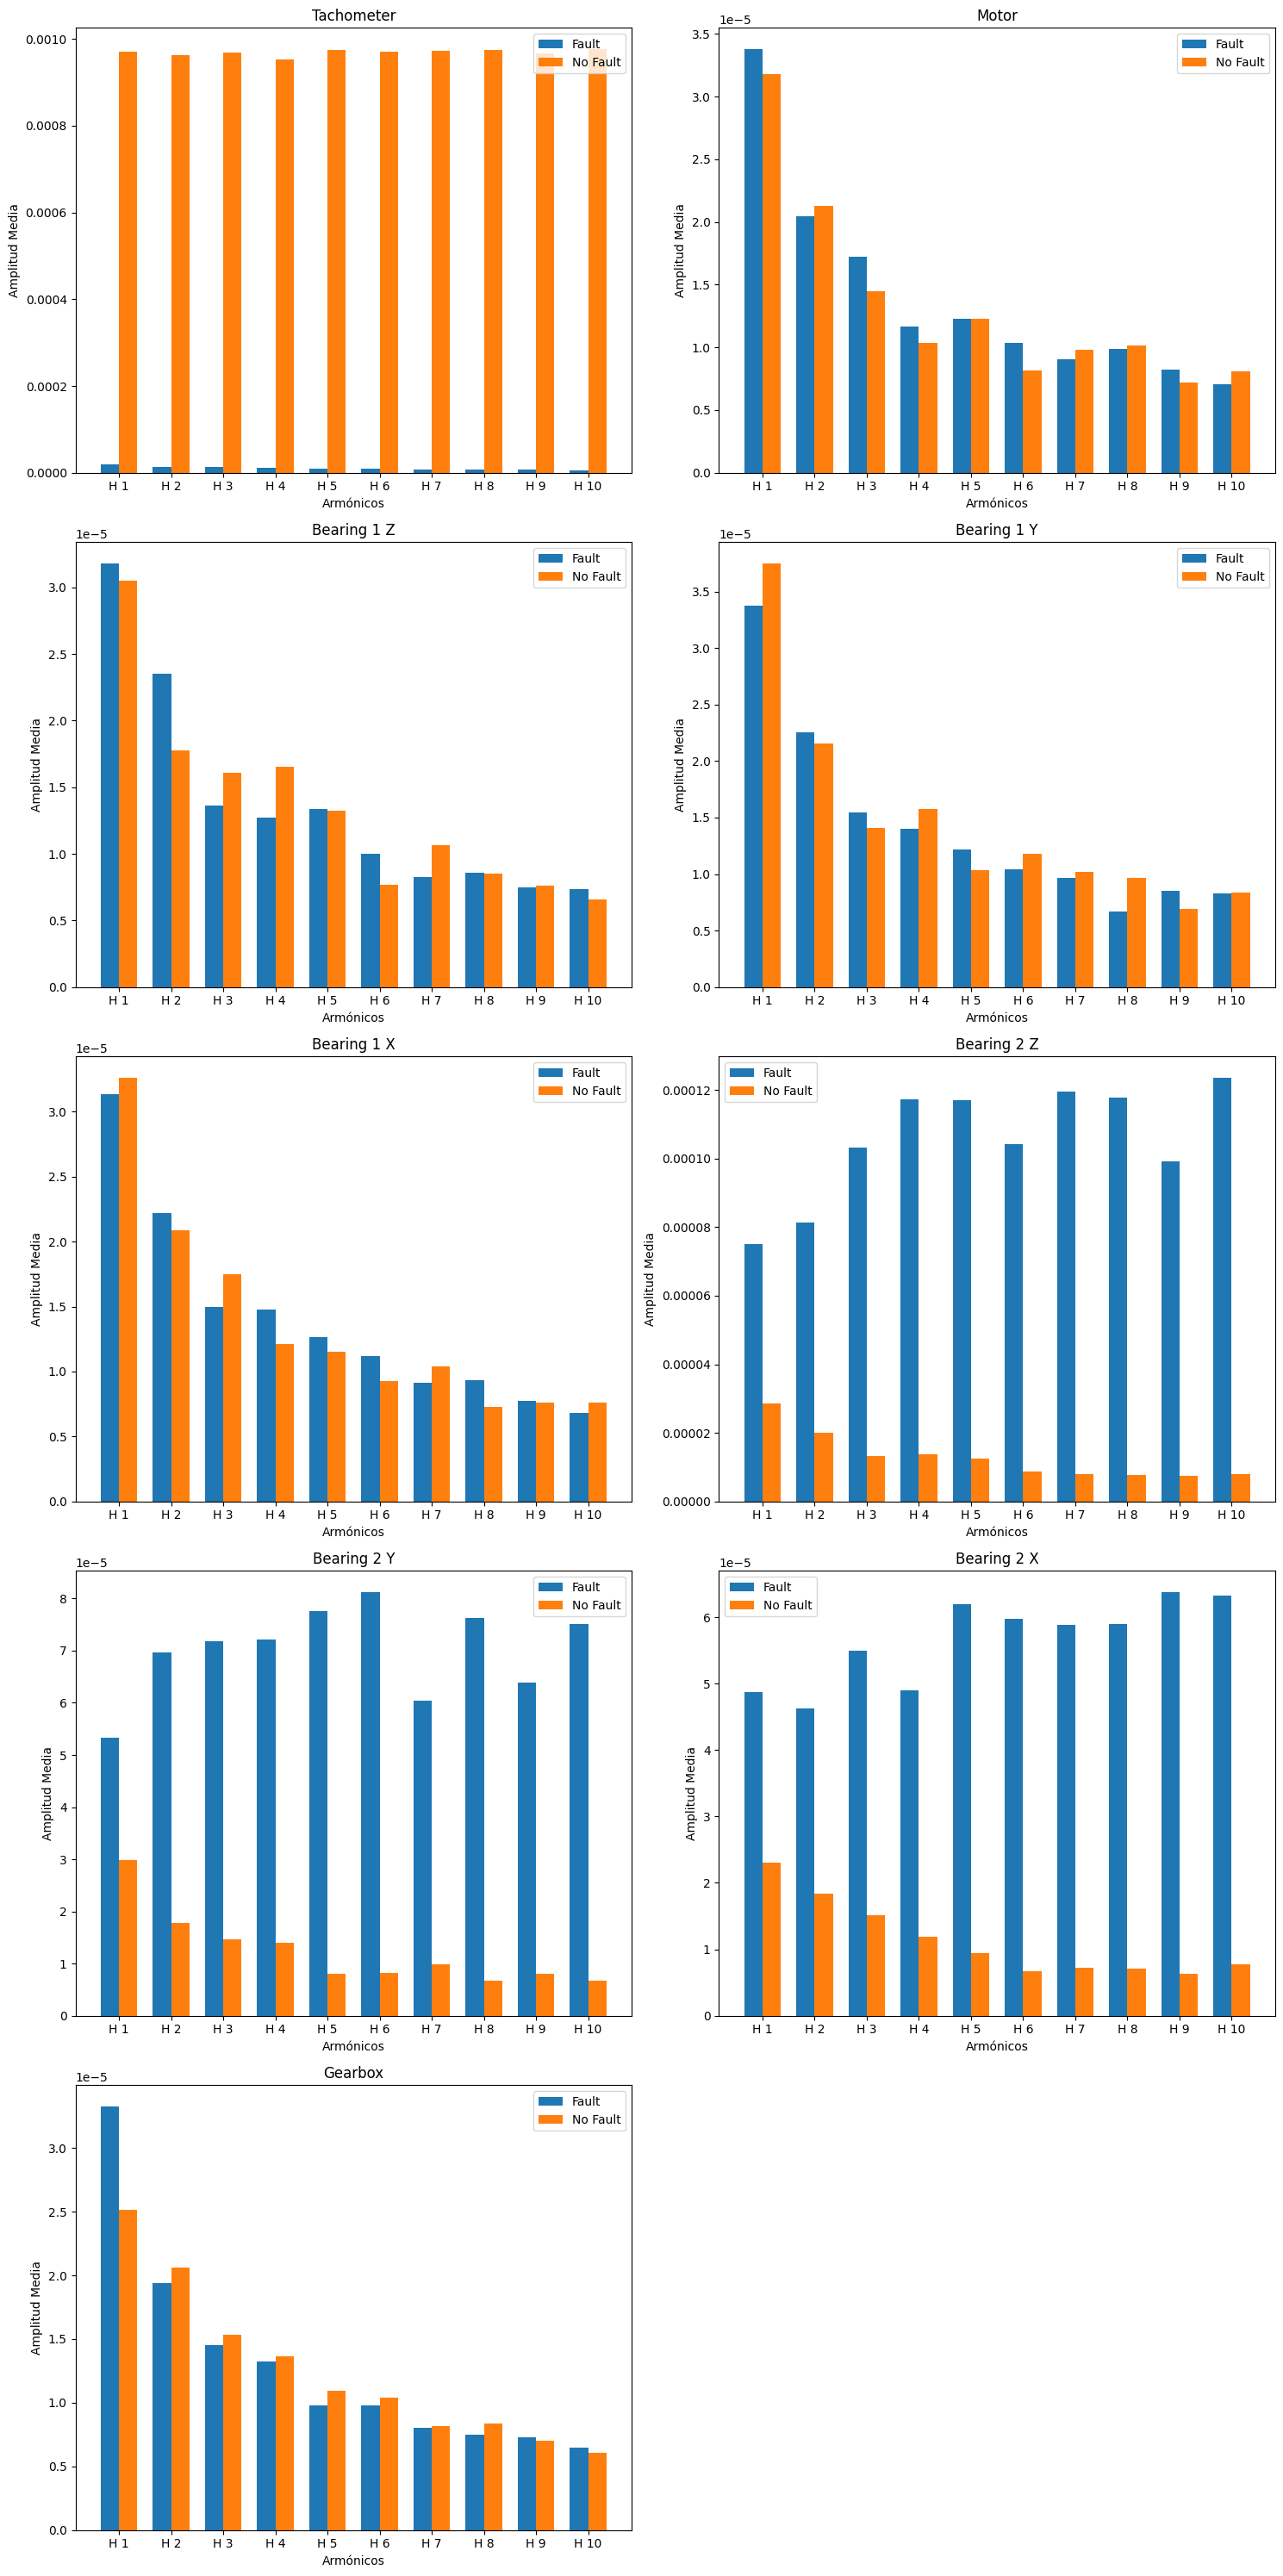

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Cargar el archivo CSV de características
df_features = pd.read_csv('C:/Users/orzus/OneDrive/Documentos/1C 2024/IA/TP/features_harmonics_be1_babe2_comb.csv')

# Filtrar los datos por escenarios de falla y no falla
df_fault = df_features[df_features['label'] == 1]
df_no_fault = df_features[df_features['label'] == 0]

# Función para plotear los armónicos de escenarios de falla y no falla superpuestos en gráficos de barras
def plot_harmonics_comparison_bar(df_fault, df_no_fault, prefix, ax):
    harmonics = [f'{prefix}_harmonic_{i}_amplitude' for i in range(1, 11)]
    
    num_bars = len(harmonics)
    bar_width = 0.35
    index = np.arange(num_bars)
    
    fault_means = [df_fault[harmonic].mean() for harmonic in harmonics]
    no_fault_means = [df_no_fault[harmonic].mean() for harmonic in harmonics]
    
    ax.bar(index, fault_means, bar_width, label='Fault')
    ax.bar(index + bar_width, no_fault_means, bar_width, label='No Fault')
    
    ax.set_xlabel('Armónicos')
    ax.set_ylabel('Amplitud Media')
    ax.set_title(f'{prefix}')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels([f'H {i}' for i in range(1, 11)])
    ax.legend()

# Lista de columnas de interés
columns_of_interest = ['Tachometer', 'Motor', 'Bearing 1 Z', 'Bearing 1 Y', 'Bearing 1 X',
                      'Bearing 2 Z', 'Bearing 2 Y', 'Bearing 2 X', 'Gearbox']

# Calcular el número necesario de filas para 2 gráficos por fila
num_rows = (len(columns_of_interest) + 1) // 2

# Crear gráficos de barras para cada columna de interés en dos columnas
fig, axes = plt.subplots(num_rows, 2, figsize=(15, num_rows * 6))

# Ajustar para tener 2 gráficos por fila
for i, col in enumerate(columns_of_interest):
    row = i // 2
    col_position = i % 2
    plot_harmonics_comparison_bar(df_fault, df_no_fault, col, axes[row, col_position])

# Si hay un número impar de gráficos, ocultar el subplot vacío
if len(columns_of_interest) % 2 != 0:
    fig.delaxes(axes[num_rows - 1, 1])

plt.tight_layout()

# Guardar la imagen
plt.savefig('be1_babe2_comb.png')

plt.show()

In [8]:
import os
import pickle
import pandas as pd
import numpy as np
from scipy.fftpack import fft
from tqdm import tqdm

def extract_harmonics(signal, prefix, sampling_rate=6400):
    signal = pd.to_numeric(signal, errors='coerce').dropna().to_numpy()
    if len(signal) == 0:
        return {}

    features = {}
    
    try:
        # Transformada de Fourier (FFT)
        freqs = fft(signal)
        freqs_abs = np.abs(freqs)
        freqs_norm = freqs_abs / len(signal)
        freqs_indices = np.fft.fftfreq(len(signal), 1/sampling_rate)
        
        # Solo extraer los primeros 5 armónicos
        num_harmonics = 10
        for i in range(1, num_harmonics + 1):
            harmonic_index = i
            if harmonic_index < len(freqs_norm):
                features[f'{prefix}_harmonic_{i}_amplitude'] = freqs_norm[harmonic_index]
            else:
                features[f'{prefix}_harmonic_{i}_amplitude'] = 0

    except Exception as e:
        print(f"Error al extraer armónicos de {prefix}: {e}")
    
    return features

def get_label_from_filename(filename):
    if '(Fault) Bearing (1) Ball & Bearing (2) Inner Trial' in filename:
        return 1
    elif '(NoFault)' in filename:
        return 0
    else:
        return None

def process_file(file_path, filename, columns_of_interest):
    try:
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
    except Exception as e:
        print(f"Error al cargar {filename}: {e}")
        return None
    
    label = get_label_from_filename(filename)
    
    if label is not None:
        file_features = {'file': filename, 'label': label}
        for col in columns_of_interest:
            if col in data:
                signal = data[col]
                col_features = extract_harmonics(signal, col)
                file_features.update(col_features)
        return file_features
    return None

directory = 'C:/Users/orzus/OneDrive/Documentos/1C 2024/IA/TP/dataset_plk/split25_plk'
output_file = 'C:/Users/orzus/OneDrive/Documentos/1C 2024/IA/TP/features_harmonics_be1_babe2_inn.csv'

columns_of_interest = ['Tachometer', 'Motor', 'Bearing 1 Z', 'Bearing 1 Y', 'Bearing 1 X',
                      'Bearing 2 Z', 'Bearing 2 Y', 'Bearing 2 X', 'Gearbox']

features_list = []

# Enfoque secuencial para depuración
for filename in tqdm(os.listdir(directory)):
    if filename.endswith(".plk"):
        file_path = os.path.join(directory, filename)
        result = process_file(file_path, filename, columns_of_interest)
        if result is not None:
            features_list.append(result)

df_features = pd.DataFrame(features_list)
df_features.to_csv(output_file, index=False)
print(f'Características de armónicos extraídas y guardadas en {output_file}')

100%|████████████████████████████████████████████████████████████████████████████████| 975/975 [00:49<00:00, 19.61it/s]

Características de armónicos extraídas y guardadas en C:/Users/orzus/OneDrive/Documentos/1C 2024/IA/TP/features_harmonics_be1_babe2_inn.csv


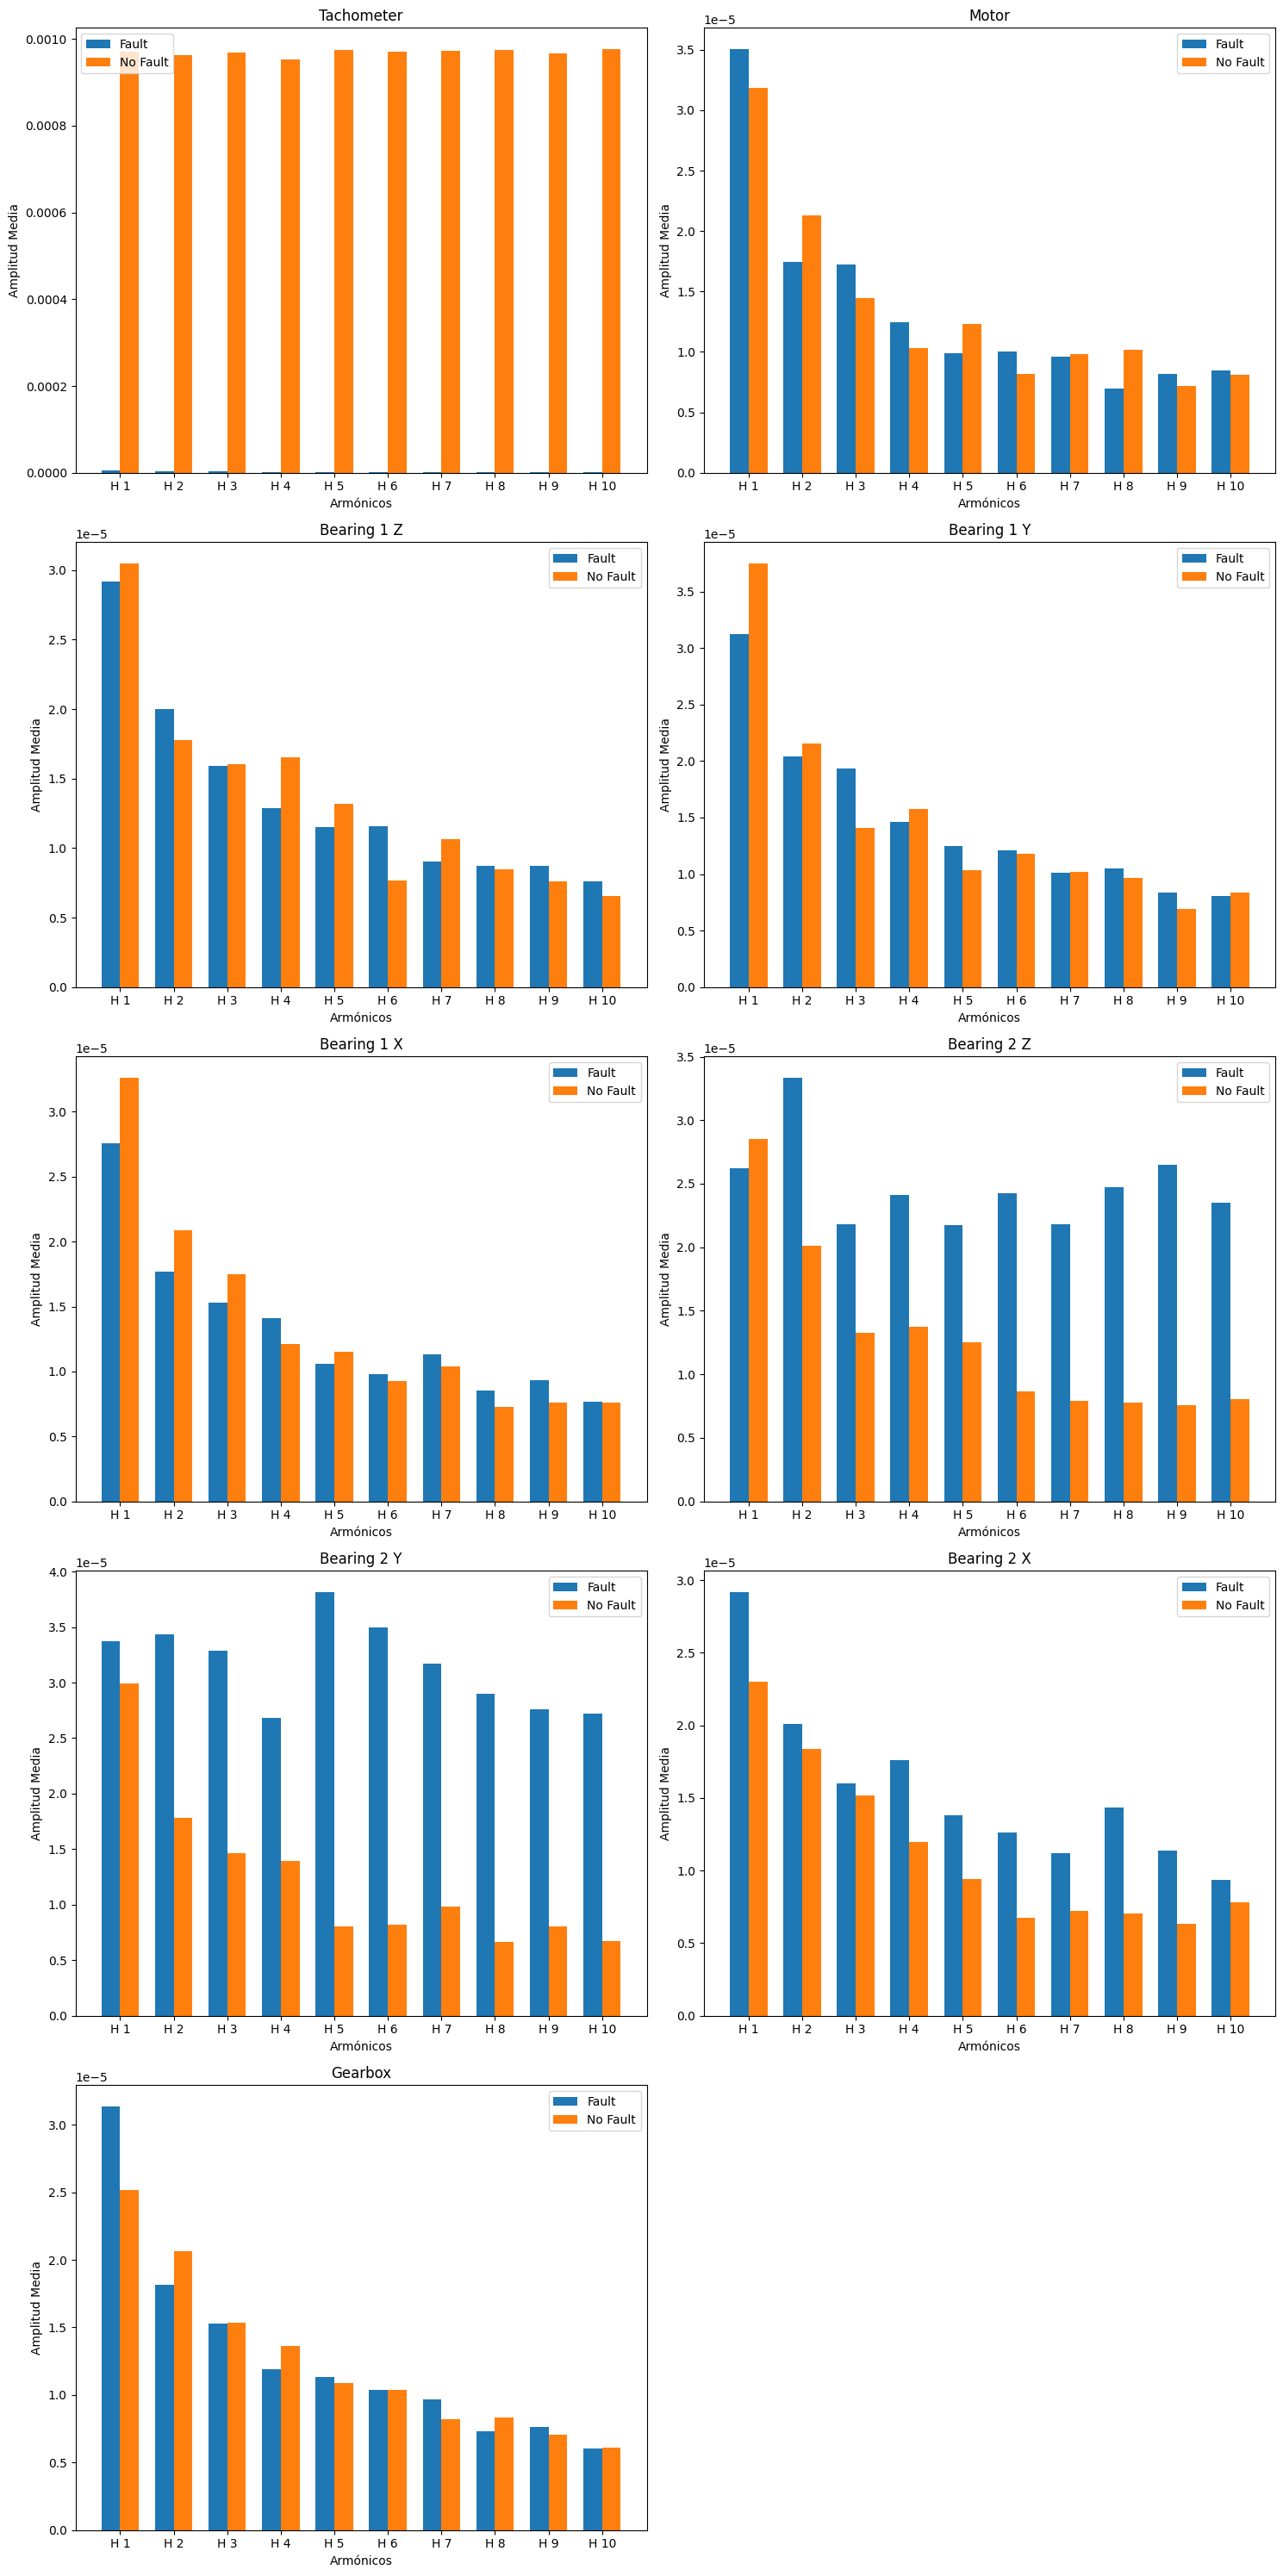

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Cargar el archivo CSV de características
df_features = pd.read_csv('C:/Users/orzus/OneDrive/Documentos/1C 2024/IA/TP/features_harmonics_be1_babe2_inn.csv')

# Filtrar los datos por escenarios de falla y no falla
df_fault = df_features[df_features['label'] == 1]
df_no_fault = df_features[df_features['label'] == 0]

# Función para plotear los armónicos de escenarios de falla y no falla superpuestos en gráficos de barras
def plot_harmonics_comparison_bar(df_fault, df_no_fault, prefix, ax):
    harmonics = [f'{prefix}_harmonic_{i}_amplitude' for i in range(1, 11)]
    
    num_bars = len(harmonics)
    bar_width = 0.35
    index = np.arange(num_bars)
    
    fault_means = [df_fault[harmonic].mean() for harmonic in harmonics]
    no_fault_means = [df_no_fault[harmonic].mean() for harmonic in harmonics]
    
    ax.bar(index, fault_means, bar_width, label='Fault')
    ax.bar(index + bar_width, no_fault_means, bar_width, label='No Fault')
    
    ax.set_xlabel('Armónicos')
    ax.set_ylabel('Amplitud Media')
    ax.set_title(f'{prefix}')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels([f'H {i}' for i in range(1, 11)])
    ax.legend()

# Lista de columnas de interés
columns_of_interest = ['Tachometer', 'Motor', 'Bearing 1 Z', 'Bearing 1 Y', 'Bearing 1 X',
                      'Bearing 2 Z', 'Bearing 2 Y', 'Bearing 2 X', 'Gearbox']

# Calcular el número necesario de filas para 2 gráficos por fila
num_rows = (len(columns_of_interest) + 1) // 2

# Crear gráficos de barras para cada columna de interés en dos columnas
fig, axes = plt.subplots(num_rows, 2, figsize=(15, num_rows * 6))

# Ajustar para tener 2 gráficos por fila
for i, col in enumerate(columns_of_interest):
    row = i // 2
    col_position = i % 2
    plot_harmonics_comparison_bar(df_fault, df_no_fault, col, axes[row, col_position])

# Si hay un número impar de gráficos, ocultar el subplot vacío
if len(columns_of_interest) % 2 != 0:
    fig.delaxes(axes[num_rows - 1, 1])

plt.tight_layout()

# Guardar la imagen
plt.savefig('be1_babe2_inn.png')

plt.show()

In [14]:
import os
import pickle
import pandas as pd
import numpy as np
from scipy.fftpack import fft
from tqdm import tqdm

def extract_harmonics(signal, prefix, sampling_rate=6400):
    signal = pd.to_numeric(signal, errors='coerce').dropna().to_numpy()
    if len(signal) == 0:
        return {}

    features = {}
    
    try:
        # Transformada de Fourier (FFT)
        freqs = fft(signal)
        freqs_abs = np.abs(freqs)
        freqs_norm = freqs_abs / len(signal)
        freqs_indices = np.fft.fftfreq(len(signal), 1/sampling_rate)
        
        # Solo extraer los primeros 10 armónicos
        num_harmonics = 10
        for i in range(1, num_harmonics + 1):
            harmonic_index = i
            if harmonic_index < len(freqs_norm):
                features[f'{prefix}_harmonic_{i}_amplitude'] = freqs_norm[harmonic_index]
            else:
                features[f'{prefix}_harmonic_{i}_amplitude'] = 0

    except Exception as e:
        print(f"Error al extraer armónicos de {prefix}: {e}")
    
    return features

def get_label_from_filename(filename):
    if '(Fault) Bearing (1) Ball & Bearing (2) Outer Trial' in filename:
        return 1
    elif '(NoFault)' in filename:
        return 0
    else:
        return None

def process_file(file_path, filename, columns_of_interest):
    try:
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
    except Exception as e:
        print(f"Error al cargar {filename}: {e}")
        return None
    
    label = get_label_from_filename(filename)
    
    if label is not None:
        file_features = {'file': filename, 'label': label}
        for col in columns_of_interest:
            if col in data:
                signal = data[col]
                col_features = extract_harmonics(signal, col)
                file_features.update(col_features)
        return file_features
    return None

directory = 'C:/Users/orzus/OneDrive/Documentos/1C 2024/IA/TP/dataset_plk/split25_plk'
output_file = 'C:/Users/orzus/OneDrive/Documentos/1C 2024/IA/TP/features_harmonics_be1_babe2_out.csv'

columns_of_interest = ['Tachometer', 'Motor', 'Bearing 1 Z', 'Bearing 1 Y', 'Bearing 1 X',
                      'Bearing 2 Z', 'Bearing 2 Y', 'Bearing 2 X', 'Gearbox']

features_list = []

# Enfoque secuencial para depuración
for filename in tqdm(os.listdir(directory)):
    if filename.endswith(".plk"):
        file_path = os.path.join(directory, filename)
        result = process_file(file_path, filename, columns_of_interest)
        if result is not None:
            features_list.append(result)

df_features = pd.DataFrame(features_list)
df_features.to_csv(output_file, index=False)
print(f'Características de armónicos extraídas y guardadas en {output_file}')

100%|████████████████████████████████████████████████████████████████████████████████| 975/975 [00:53<00:00, 18.38it/s]

Características de armónicos extraídas y guardadas en C:/Users/orzus/OneDrive/Documentos/1C 2024/IA/TP/features_harmonics_be1_babe2_out.csv


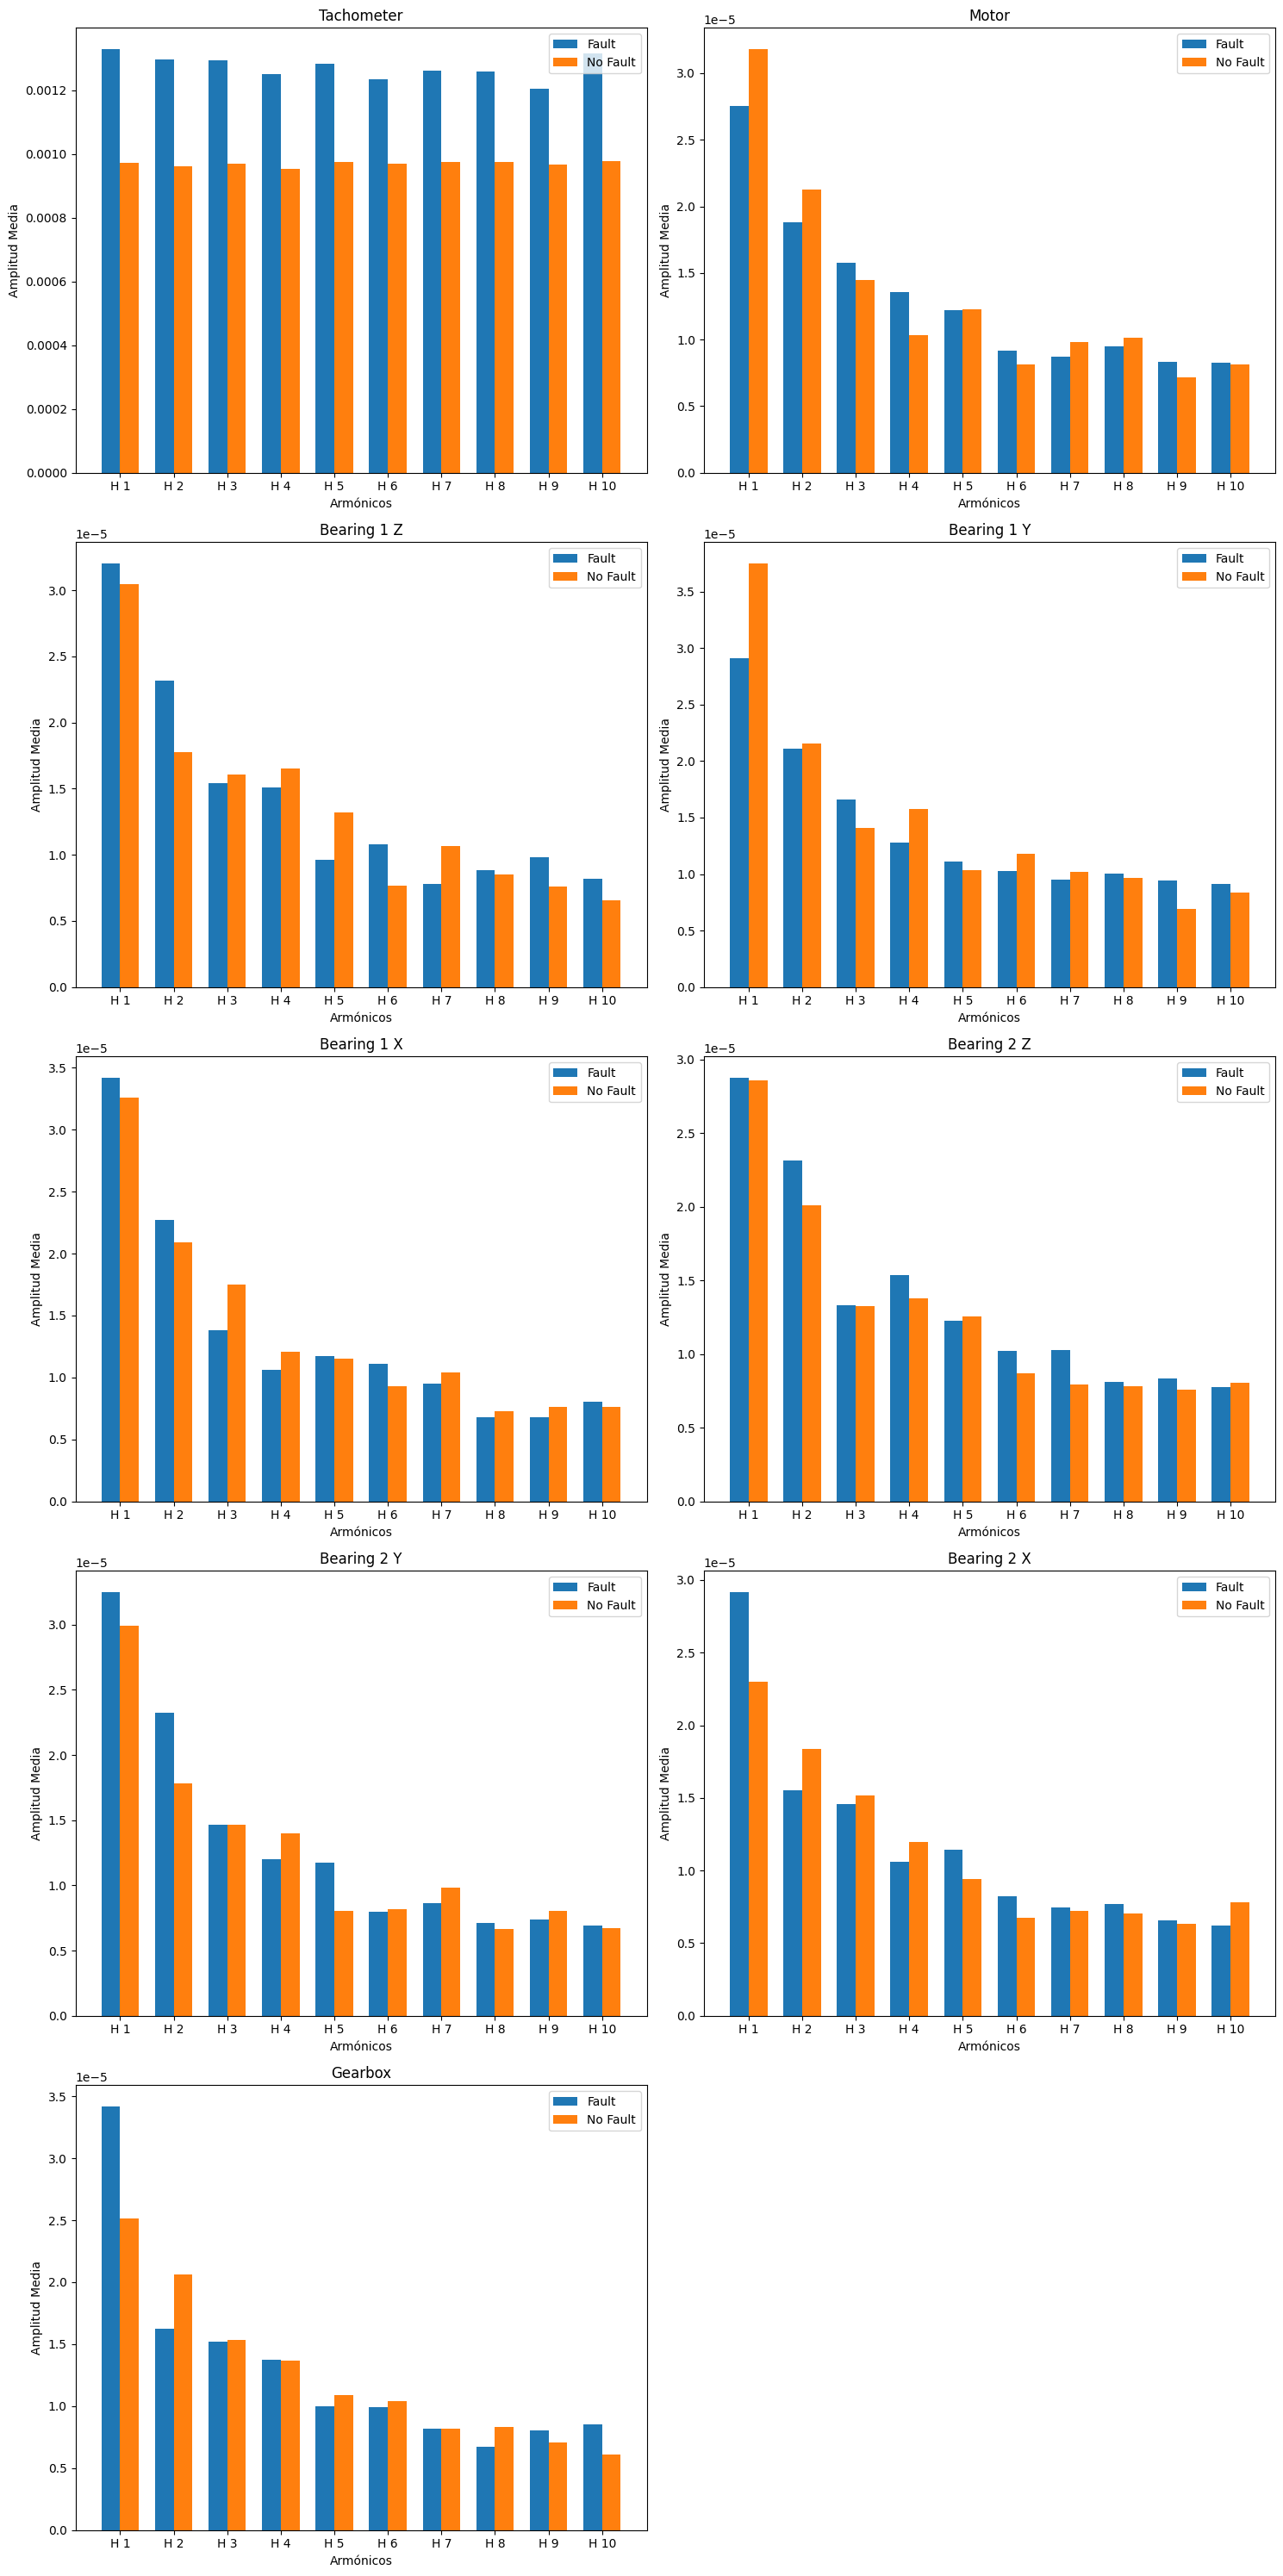

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Cargar el archivo CSV de características
df_features = pd.read_csv('C:/Users/orzus/OneDrive/Documentos/1C 2024/IA/TP/features_harmonics_be1_babe2_out.csv')

# Filtrar los datos por escenarios de falla y no falla
df_fault = df_features[df_features['label'] == 1]
df_no_fault = df_features[df_features['label'] == 0]

# Función para plotear los armónicos de escenarios de falla y no falla superpuestos en gráficos de barras
def plot_harmonics_comparison_bar(df_fault, df_no_fault, prefix, ax):
    harmonics = [f'{prefix}_harmonic_{i}_amplitude' for i in range(1, 11)]
    
    num_bars = len(harmonics)
    bar_width = 0.35
    index = np.arange(num_bars)
    
    fault_means = [df_fault[harmonic].mean() for harmonic in harmonics]
    no_fault_means = [df_no_fault[harmonic].mean() for harmonic in harmonics]
    
    ax.bar(index, fault_means, bar_width, label='Fault')
    ax.bar(index + bar_width, no_fault_means, bar_width, label='No Fault')
    
    ax.set_xlabel('Armónicos')
    ax.set_ylabel('Amplitud Media')
    ax.set_title(f'{prefix}')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels([f'H {i}' for i in range(1, 11)])
    ax.legend()

# Lista de columnas de interés
columns_of_interest = ['Tachometer', 'Motor', 'Bearing 1 Z', 'Bearing 1 Y', 'Bearing 1 X',
                      'Bearing 2 Z', 'Bearing 2 Y', 'Bearing 2 X', 'Gearbox']

# Calcular el número necesario de filas para 2 gráficos por fila
num_rows = (len(columns_of_interest) + 1) // 2

# Crear gráficos de barras para cada columna de interés en dos columnas
fig, axes = plt.subplots(num_rows, 2, figsize=(15, num_rows * 6))

# Ajustar para tener 2 gráficos por fila
for i, col in enumerate(columns_of_interest):
    row = i // 2
    col_position = i % 2
    plot_harmonics_comparison_bar(df_fault, df_no_fault, col, axes[row, col_position])

# Si hay un número impar de gráficos, ocultar el subplot vacío
if len(columns_of_interest) % 2 != 0:
    fig.delaxes(axes[num_rows - 1, 1])

plt.tight_layout()

# Guardar la imagen
plt.savefig('be1_babe2_out.png')

plt.show()

In [16]:
import os
import pickle
import pandas as pd
import numpy as np
from scipy.fftpack import fft
from tqdm import tqdm

def extract_harmonics(signal, prefix, sampling_rate=6400):
    signal = pd.to_numeric(signal, errors='coerce').dropna().to_numpy()
    if len(signal) == 0:
        return {}

    features = {}
    
    try:
        # Transformada de Fourier (FFT)
        freqs = fft(signal)
        freqs_abs = np.abs(freqs)
        freqs_norm = freqs_abs / len(signal)
        freqs_indices = np.fft.fftfreq(len(signal), 1/sampling_rate)
        
        # Solo extraer los primeros 10 armónicos
        num_harmonics = 10
        for i in range(1, num_harmonics + 1):
            harmonic_index = i
            if harmonic_index < len(freqs_norm):
                features[f'{prefix}_harmonic_{i}_amplitude'] = freqs_norm[harmonic_index]
            else:
                features[f'{prefix}_harmonic_{i}_amplitude'] = 0

    except Exception as e:
        print(f"Error al extraer armónicos de {prefix}: {e}")
    
    return features

def get_label_from_filename(filename):
    if '(Fault) Bearing (1) Ball & Shaft Fault (Centerally bent) Trial' in filename:
        return 1
    elif '(NoFault)' in filename:
        return 0
    else:
        return None

def process_file(file_path, filename, columns_of_interest):
    try:
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
    except Exception as e:
        print(f"Error al cargar {filename}: {e}")
        return None
    
    label = get_label_from_filename(filename)
    
    if label is not None:
        file_features = {'file': filename, 'label': label}
        for col in columns_of_interest:
            if col in data:
                signal = data[col]
                col_features = extract_harmonics(signal, col)
                file_features.update(col_features)
        return file_features
    return None

directory = 'C:/Users/orzus/OneDrive/Documentos/1C 2024/IA/TP/dataset_plk/split25_plk'
output_file = 'C:/Users/orzus/OneDrive/Documentos/1C 2024/IA/TP/features_harmonics_be1_bash2_centbent.csv'

columns_of_interest = ['Tachometer', 'Motor', 'Bearing 1 Z', 'Bearing 1 Y', 'Bearing 1 X',
                      'Bearing 2 Z', 'Bearing 2 Y', 'Bearing 2 X', 'Gearbox']

features_list = []

# Enfoque secuencial para depuración
for filename in tqdm(os.listdir(directory)):
    if filename.endswith(".plk"):
        file_path = os.path.join(directory, filename)
        result = process_file(file_path, filename, columns_of_interest)
        if result is not None:
            features_list.append(result)

df_features = pd.DataFrame(features_list)
df_features.to_csv(output_file, index=False)
print(f'Características de armónicos extraídas y guardadas en {output_file}')

100%|████████████████████████████████████████████████████████████████████████████████| 975/975 [00:51<00:00, 19.07it/s]

Características de armónicos extraídas y guardadas en C:/Users/orzus/OneDrive/Documentos/1C 2024/IA/TP/features_harmonics_be1_bash2_centbent.csv


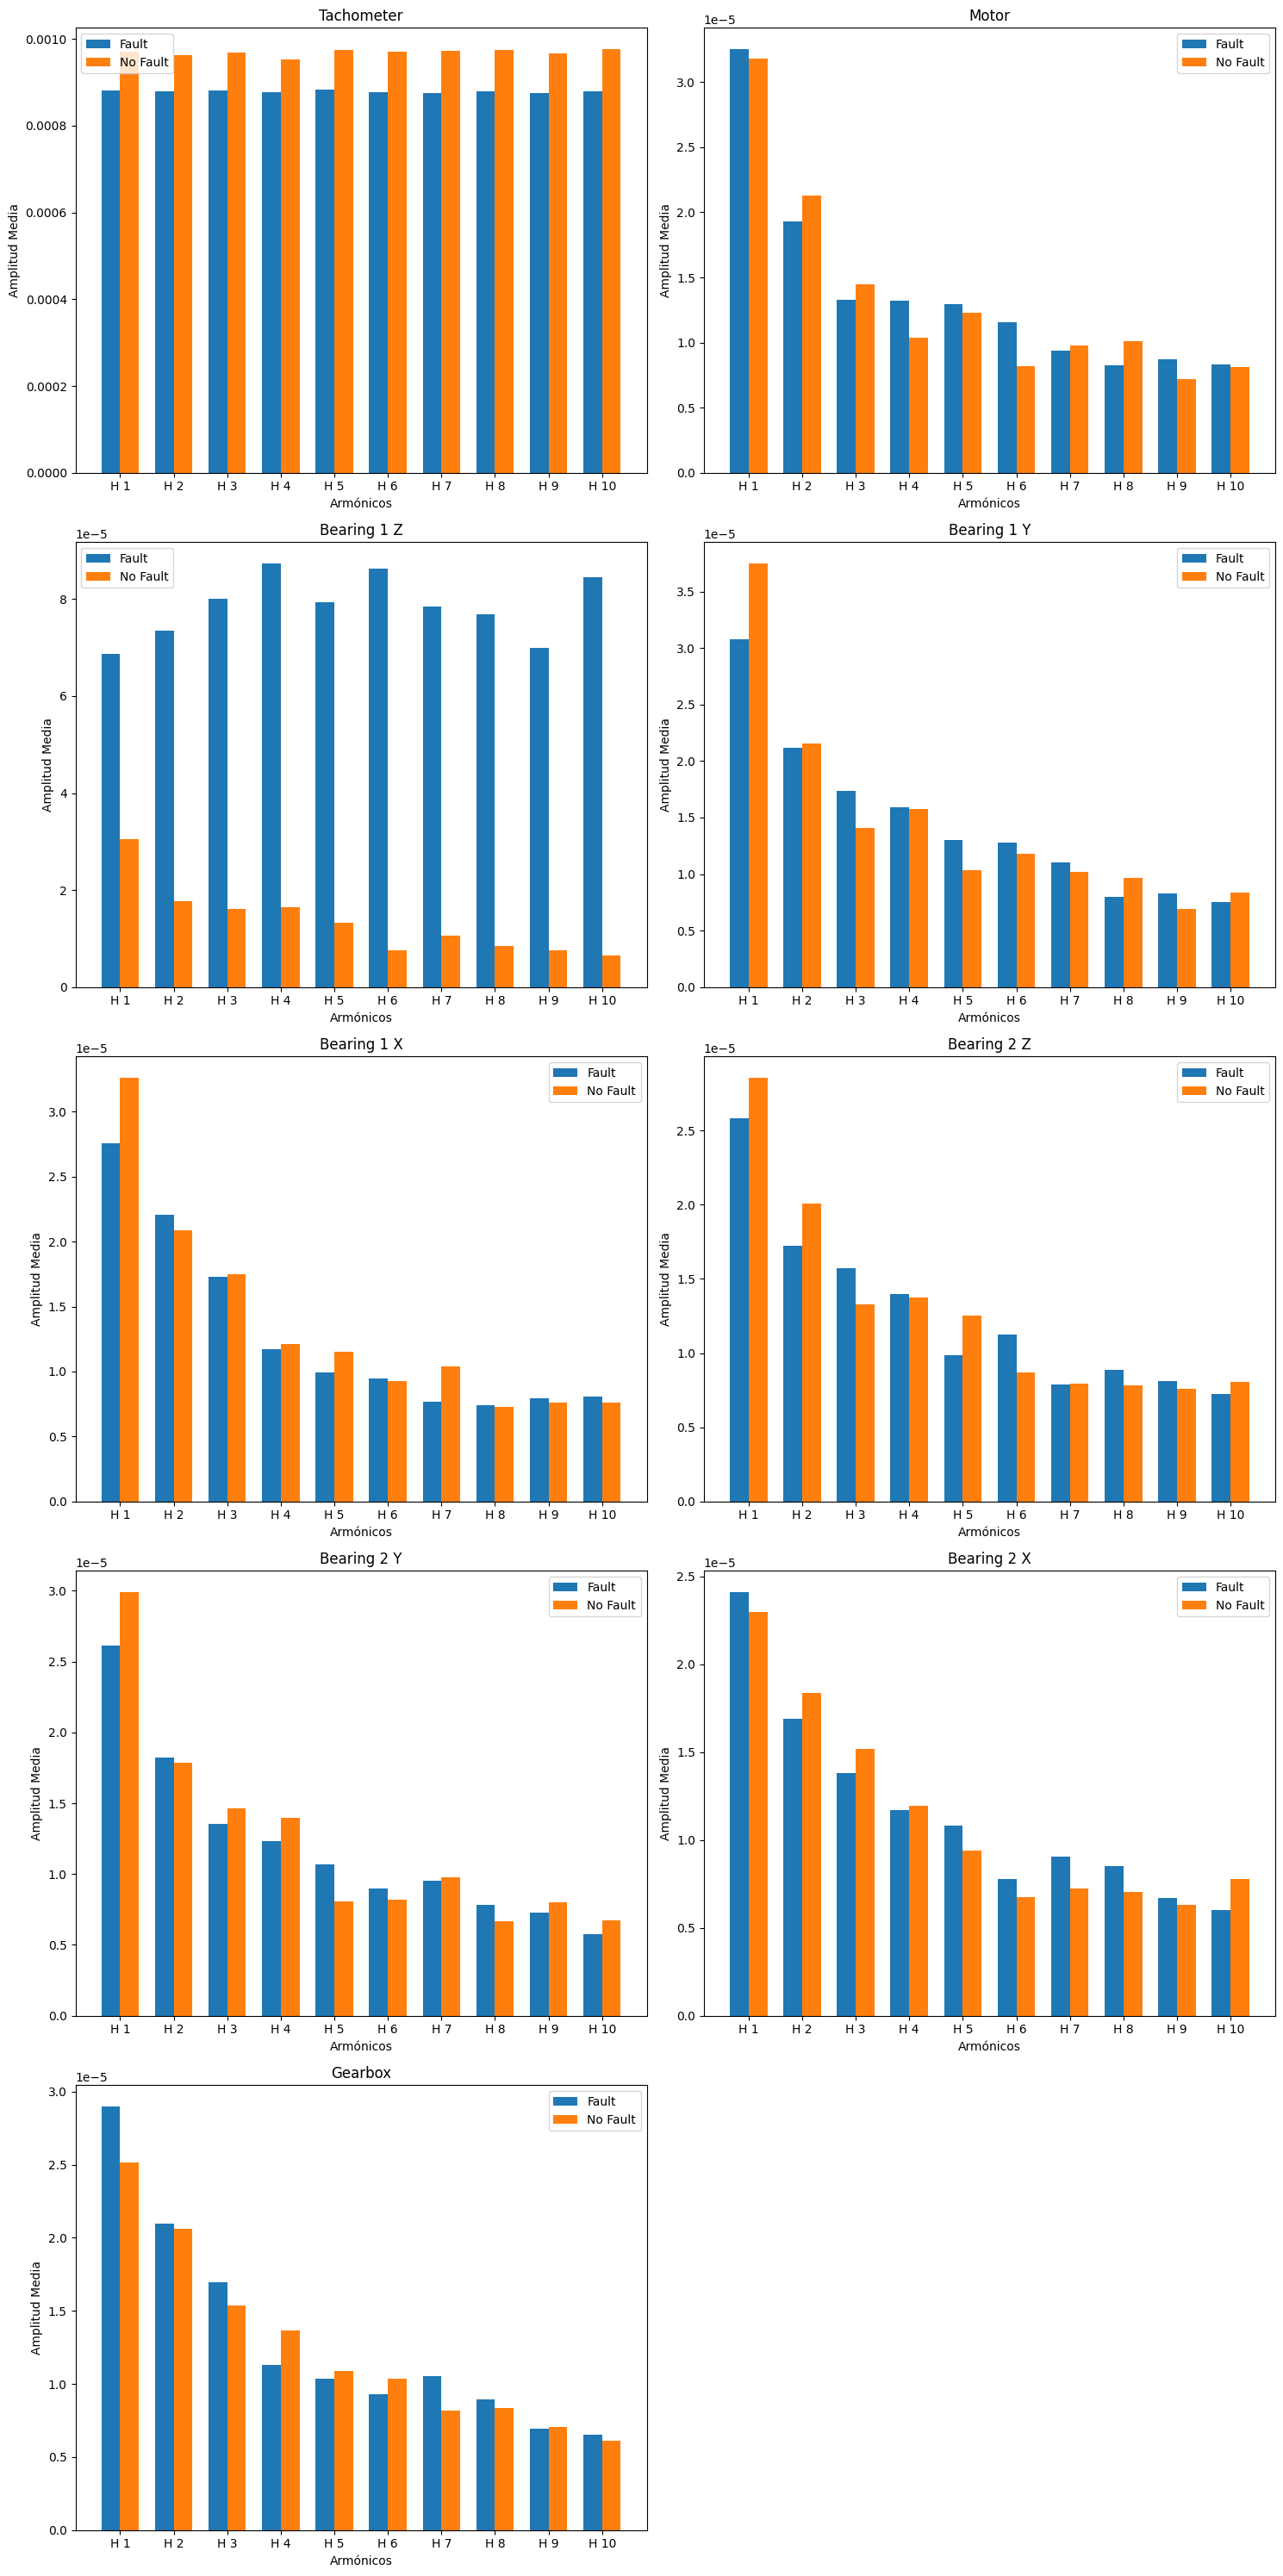

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Cargar el archivo CSV de características
df_features = pd.read_csv('C:/Users/orzus/OneDrive/Documentos/1C 2024/IA/TP/features_harmonics_be1_bash2_centbent.csv')

# Filtrar los datos por escenarios de falla y no falla
df_fault = df_features[df_features['label'] == 1]
df_no_fault = df_features[df_features['label'] == 0]

# Función para plotear los armónicos de escenarios de falla y no falla superpuestos en gráficos de barras
def plot_harmonics_comparison_bar(df_fault, df_no_fault, prefix, ax):
    harmonics = [f'{prefix}_harmonic_{i}_amplitude' for i in range(1, 11)]
    
    num_bars = len(harmonics)
    bar_width = 0.35
    index = np.arange(num_bars)
    
    fault_means = [df_fault[harmonic].mean() for harmonic in harmonics]
    no_fault_means = [df_no_fault[harmonic].mean() for harmonic in harmonics]
    
    ax.bar(index, fault_means, bar_width, label='Fault')
    ax.bar(index + bar_width, no_fault_means, bar_width, label='No Fault')
    
    ax.set_xlabel('Armónicos')
    ax.set_ylabel('Amplitud Media')
    ax.set_title(f'{prefix}')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels([f'H {i}' for i in range(1, 11)])
    ax.legend()

# Lista de columnas de interés
columns_of_interest = ['Tachometer', 'Motor', 'Bearing 1 Z', 'Bearing 1 Y', 'Bearing 1 X',
                      'Bearing 2 Z', 'Bearing 2 Y', 'Bearing 2 X', 'Gearbox']

# Calcular el número necesario de filas para 2 gráficos por fila
num_rows = (len(columns_of_interest) + 1) // 2

# Crear gráficos de barras para cada columna de interés en dos columnas
fig, axes = plt.subplots(num_rows, 2, figsize=(15, num_rows * 6))

# Ajustar para tener 2 gráficos por fila
for i, col in enumerate(columns_of_interest):
    row = i // 2
    col_position = i % 2
    plot_harmonics_comparison_bar(df_fault, df_no_fault, col, axes[row, col_position])

# Si hay un número impar de gráficos, ocultar el subplot vacío
if len(columns_of_interest) % 2 != 0:
    fig.delaxes(axes[num_rows - 1, 1])

plt.tight_layout()

# Guardar la imagen
plt.savefig('be1_bash2_centbent.png')

plt.show()

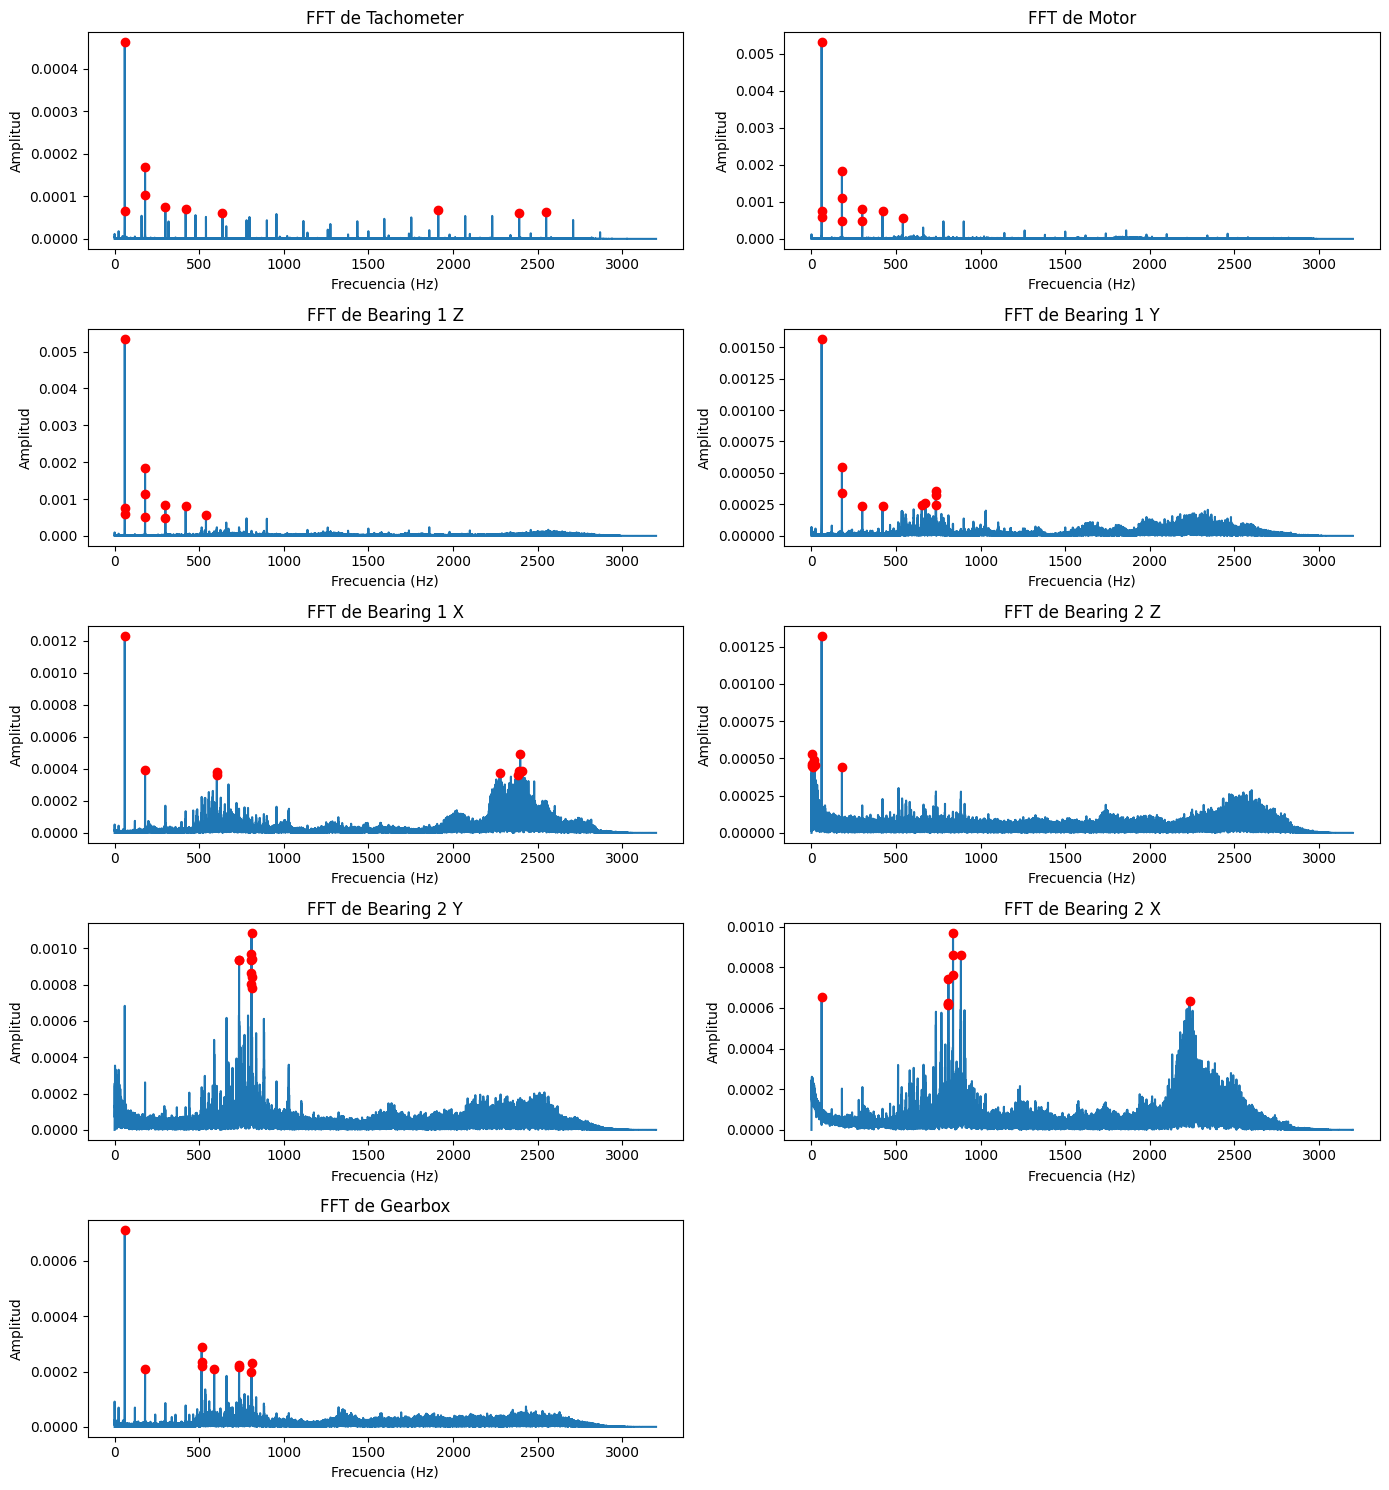

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

# Cargar el archivo .plk
file_path = 'C:/Users/orzus/OneDrive/Documentos/1C 2024/IA/TP/dataset_plk/split25_plk/(Fault) Bearing (1) Ball & Bearing (2) Combination Trial 1.plk'
data = pd.read_pickle(file_path)

# Convertir la columna 'Time' a valores numéricos
data['Time'] = pd.to_numeric(data['Time'])

# Función para graficar la FFT de una columna dada
def plot_fft(column_data, column_name, ax):
    N = len(column_data)
    T = data['Time'].iloc[1] - data['Time'].iloc[0]  # Intervalo de muestreo
    yf = fft(column_data)
    xf = fftfreq(N, T)[:N//2]

    # Eliminar el pico de frecuencia cero estableciéndolo a cero
    yf[0] = 0

    # Graficar la FFT
    ax.plot(xf, 2.0/N * np.abs(yf[:N//2]), label='FFT')

    # Identificar los picos de los primeros 10 armónicos
    amplitudes = 2.0/N * np.abs(yf[:N//2])
    peak_indices = np.argsort(amplitudes)[-10:][::-1]  # Obtener los índices de los 10 picos más altos

    # Dibujar círculos rojos en los picos
    for peak in peak_indices:
        ax.plot(xf[peak], amplitudes[peak], 'ro')

    ax.set_title(f'FFT de {column_name}')
    ax.set_xlabel('Frecuencia (Hz)')
    ax.set_ylabel('Amplitud')

# Columnas a procesar (excluyendo 'Time')
columns_to_process = [col for col in data.columns if col != 'Time']

# Ajustar la creación de subplots para manejar un número impar de columnas
n_cols = 2
n_rows = (len(columns_to_process) + 1) // n_cols

# Crear subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, 3*n_rows))

# Aplanar la matriz de ejes para iteración fácil
axes = axes.flatten()

# Graficar la FFT para cada columna
for i, col in enumerate(columns_to_process):
    plot_fft(data[col], col, axes[i])

# Eliminar cualquier subplot no utilizado
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

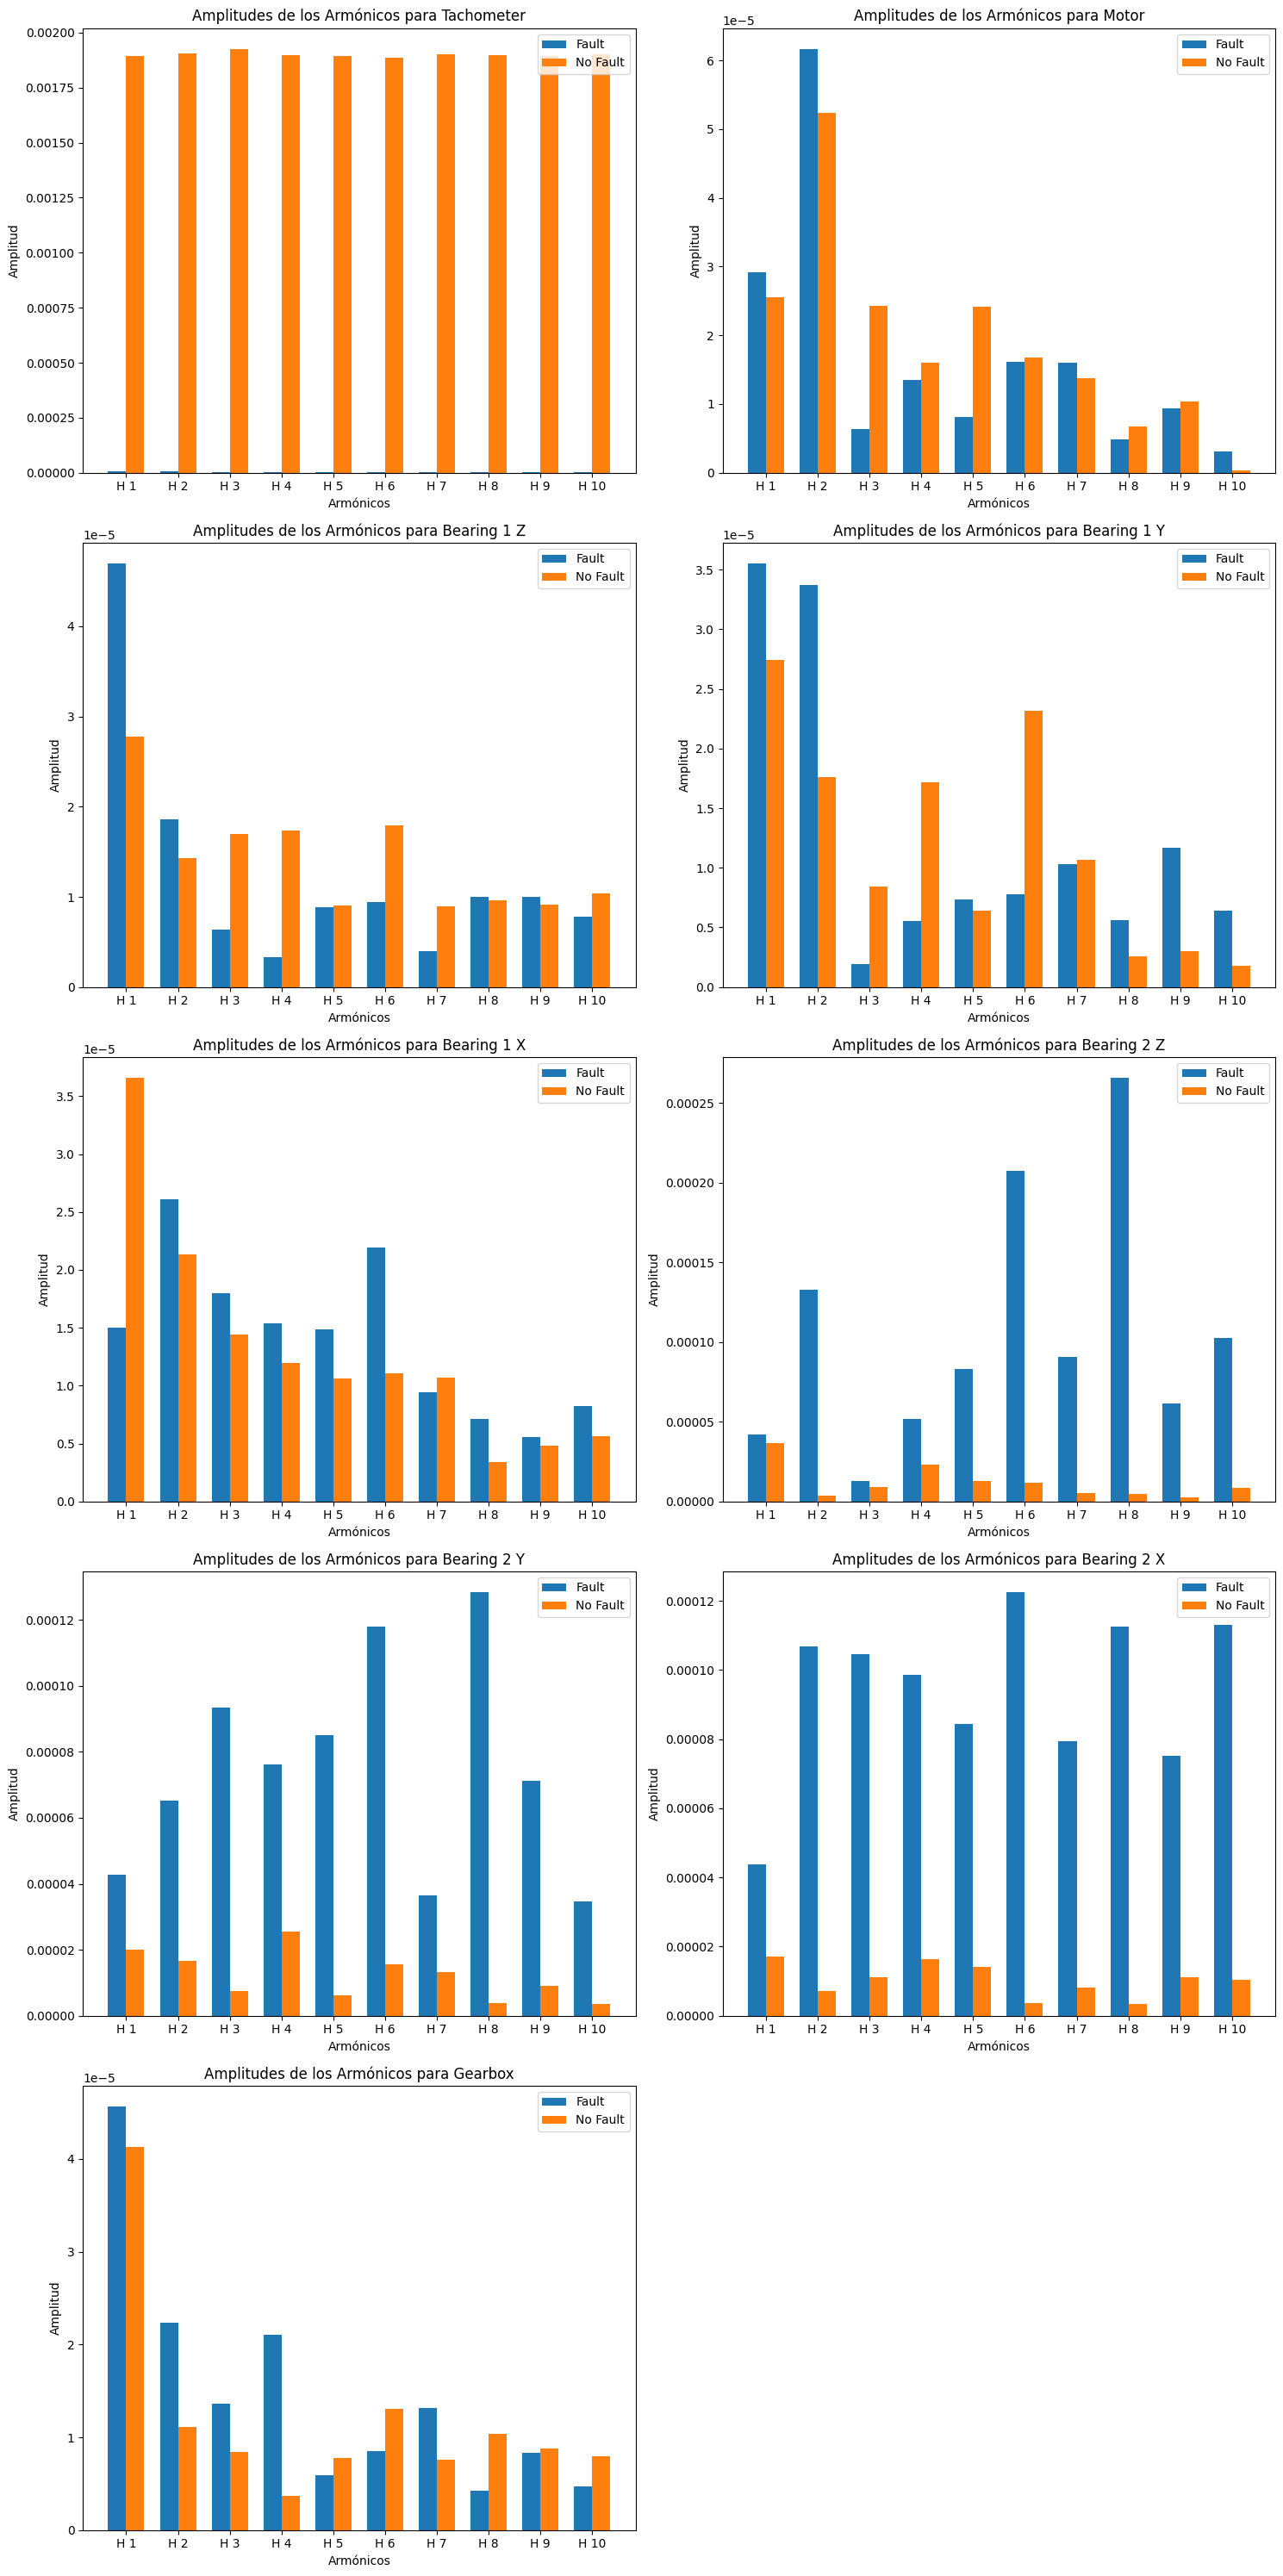

In [35]:
import pandas as pd
import numpy as np
from scipy.fftpack import fft
import matplotlib.pyplot as plt

# Cargar el archivo CSV de características
file_path = 'C:/Users/orzus/OneDrive/Documentos/1C 2024/IA/TP/features_harmonics_be1_babe2_comb.csv'
df_features = pd.read_csv(file_path)

# Filtrar los datos por escenarios de falla y no falla
df_fault = df_features[df_features['label'] == 1]
df_no_fault = df_features[df_features['label'] == 0]

def get_top_harmonics(df, column_prefix, num_harmonics=10):
    harmonic_columns = [f'{column_prefix}_harmonic_{i}_amplitude' for i in range(1, num_harmonics + 1)]
    harmonics = df[harmonic_columns].iloc[0].values
    frequencies = np.fft.fftfreq(len(harmonics) * 2, 1/6400)[:num_harmonics]  # Asegurar que las frecuencias sean positivas
    return list(zip(harmonics, frequencies))

def get_amplitudes_at_frequencies(df, column_prefix, frequencies, num_harmonics=10):
    harmonic_columns = [f'{column_prefix}_harmonic_{i}_amplitude' for i in range(1, num_harmonics + 1)]
    amplitudes = df[harmonic_columns].iloc[0].values
    amplitude_dict = {freq: amp for freq, amp in zip(frequencies, amplitudes)}
    return amplitude_dict

def plot_harmonics_comparison(harmonics_fault, amplitudes_no_fault, column_name, ax):
    frequencies_fault = [freq for amp, freq in harmonics_fault]
    amplitudes_fault = [amp for amp, freq in harmonics_fault]
    amplitudes_no_fault = [amplitudes_no_fault[freq] for freq in frequencies_fault]
    
    bar_width = 0.35
    index = np.arange(len(frequencies_fault))
    
    ax.bar(index, amplitudes_fault, bar_width, label='Fault')
    ax.bar(index + bar_width, amplitudes_no_fault, bar_width, label='No Fault')
    
    ax.set_xlabel('Armónicos')
    ax.set_ylabel('Amplitud')
    ax.set_title(f'Amplitudes de los Armónicos para {column_name}')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels([f'H {i}' for i in range(1, len(frequencies_fault) + 1)])
    ax.legend()

columns_of_interest = ['Tachometer', 'Motor', 'Bearing 1 Z', 'Bearing 1 Y', 'Bearing 1 X',
                      'Bearing 2 Z', 'Bearing 2 Y', 'Bearing 2 X', 'Gearbox']

num_columns = 2
num_rows = (len(columns_of_interest) + 1) // num_columns

fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 6))

for i, col in enumerate(columns_of_interest):
    row = i // num_columns
    col_position = i % num_columns
    harmonics_fault = get_top_harmonics(df_fault, col)
    frequencies_fault = [freq for amp, freq in harmonics_fault]
    amplitudes_no_fault = get_amplitudes_at_frequencies(df_no_fault, col, frequencies_fault)
    
    plot_harmonics_comparison(harmonics_fault, amplitudes_no_fault, col, axes[row, col_position])

# Si hay un número impar de gráficos, ocultar el último subplot vacío
if len(columns_of_interest) % num_columns != 0:
    fig.delaxes(axes[num_rows - 1, 1])

plt.tight_layout()
plt.savefig('be1_babe2_comb_mod.png')
plt.show()

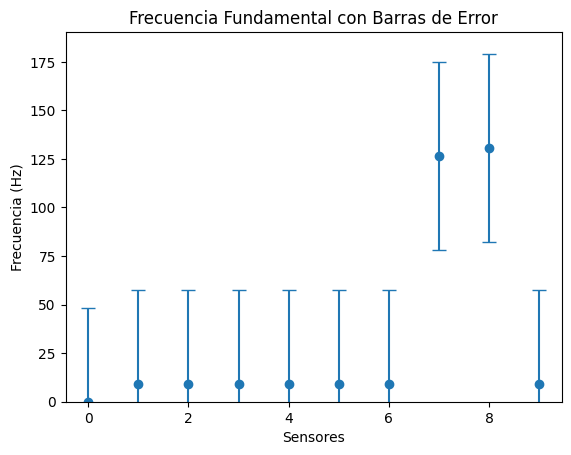

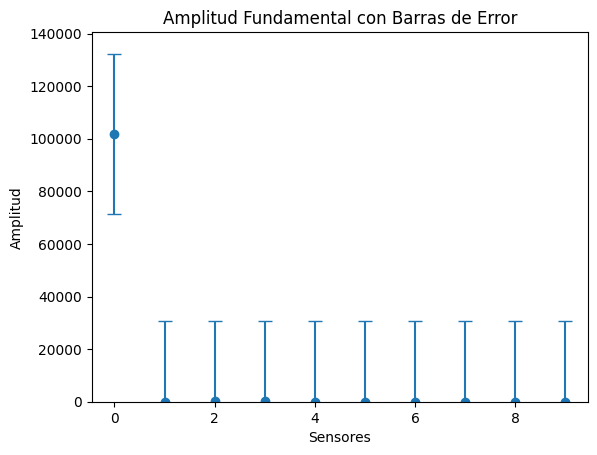

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Cargar el archivo PLK
df = pd.read_pickle('C:/Users/orzus/OneDrive/Documentos/1C 2024/IA/TP/dataset_plk/split25_plk/(Fault) Bearing (1) Ball & Bearing (2) Combination Trial 1.plk')

def obtener_fft(senal, fs):
    N = len(senal)
    fft_vals = np.fft.fft(senal)
    freqs = np.fft.fftfreq(N, 1/fs)
    half_N = N // 2
    fft_vals = np.abs(fft_vals[:half_N])  # Tomamos solo la magnitud
    freqs = freqs[:half_N]
    # Filtramos solo las frecuencias positivas
    positive_freq_idx = freqs > 0
    return freqs[positive_freq_idx], fft_vals[positive_freq_idx]

def obtener_frecuencia_fundamental(frecuencia, amplitud):
    indice_fundamental = np.argmax(amplitud)
    return frecuencia[indice_fundamental], amplitud[indice_fundamental]

fs = 1000  # Frecuencia de muestreo en Hz
frecuencias_fund = []
amplitudes_fund = []

for sensor in df.columns:
    freqs, amps = obtener_fft(df[sensor].values, fs)
    if len(freqs) > 0:  # Verificamos que haya frecuencias positivas
        freq_fund, amp_fund = obtener_frecuencia_fundamental(freqs, amps)
        frecuencias_fund.append(freq_fund)
        amplitudes_fund.append(amp_fund)

if len(frecuencias_fund) > 0:
    media_frec = np.mean(frecuencias_fund)
    desviacion_frec = np.std(frecuencias_fund)
    media_amp = np.mean(amplitudes_fund)
    desviacion_amp = np.std(amplitudes_fund)

    # Gráfico para la frecuencia fundamental
    fig, ax = plt.subplots()
    ax.errorbar(range(len(frecuencias_fund)), frecuencias_fund, yerr=desviacion_frec, fmt='o', capsize=5)
    ax.set_xlabel('Sensores')
    ax.set_ylabel('Frecuencia (Hz)')
    ax.set_title('Frecuencia Fundamental con Barras de Error')
    ax.set_ylim(bottom=0)  # Asegura que el eje y comience en 0
    plt.show()

    # Gráfico para la amplitud fundamental
    fig, ax = plt.subplots()
    ax.errorbar(range(len(amplitudes_fund)), amplitudes_fund, yerr=desviacion_amp, fmt='o', capsize=5)
    ax.set_xlabel('Sensores')
    ax.set_ylabel('Amplitud')
    ax.set_title('Amplitud Fundamental con Barras de Error')
    ax.set_ylim(bottom=0)  # Asegura que el eje y comience en 0
    plt.show()
else:
    print("No se encontraron frecuencias positivas en los datos.")